# Project 4: Web Scraping Job Postings
***

**1. Project Scope**

**2. Executive Summary**

**3. Factors that Impact Salary**
    1. Data Cleaning and Preprocessing
    2. EDA
    3. Modelling
    4. Findings
**4. Factors that distinguish between Data Scientist Jobs VS other data jobs**
    1. Data Cleaning and Preprocessing
    2. EDA
    3. Modelling
    4. Findings
**5. Appendix: Web Scraping Code**
***

# Project Scope

**Determine industry factors that are most important in predicting salaries of data-related jobs**
- Find out what factors most directly impact salary
- Build a binary classification model using features that impact salary. E.g. Job Title, Industry, Seniority, Company, Job Description, Responsibilities to see if they impact salary
- Identify most significant features overall
- Identify skills and keywords with the most impact on high/low salary

<br>
**Determine factors that distinguish Data Science jobs VS other data-related jobs**
- Find out what factors set data scientists apart the most
- Build binary classification model to predict Data Science jobs against other data-related jobs

# Executive Summary 

Factors most directly impacting salary:
- Seniority: Executive/Fresh vs Manager
- Industry: Sciences/Laboratory/R&D doesn't pay as well as industries like Banking and Finance
- While textual information from the job summary did help to improve the model, simply predicting high/low salaries with seniority, industry and employment type gave us an accuracy score of 76%

Significant keywords:
- Data Analysis, Computer Science, Big Data
- In the EDA, we also see that data scientist requirements like modelling, mining and predictive analytics tend to earn higher salaries

Factors/Keywords setting Data Scientists apart from other data roles:
- Machine Learning Algorithms, Data Mining, Deep Learning, Statistical Modelling, Time Series, ScikitLearn

Model achieved an accuracy score of 80% on the test data. However, the model was unable to predict whether or not the job posting was a Data Science job as accurately as it could predict non-Data Science jobs. The probability threshold had to be bought down to 0.2 before the model was able to classify more accurately

# Factors that Impact Salary (Q1)

### 1. Loading in jobs data and libraries

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from os import listdir
import string, re
import itertools

import nltk
from nltk.corpus import stopwords
from textblob import TextBlob, Word
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import stop_words

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
#from sklearn.model_selection import GridSearchCV

In [2]:
completed = [file for file in listdir('./jobs-data') if file != '.DS_Store']
completed

['data_architect_jobs.csv',
 'sql_jobs.csv',
 'python_jobs.csv',
 'data_science_jobs.csv',
 'business_intelligence_jobs.csv',
 'data_scientist_jobs.csv',
 'big_data_jobs.csv',
 'data_analysis_jobs.csv',
 'data_analyst_jobs.csv',
 'artificial_intelligence_jobs.csv',
 'machine_learning_jobs.csv',
 'ai_jobs.csv',
 'data_engineer_jobs.csv',
 'machine_learning_engineer_jobs.csv']

In [3]:
for i, file in enumerate(completed):
    if i != 0:
        job_query = pd.read_csv('./jobs-data/{}'.format(file))
        job_query['search_query'] = file[:-9]
        jobs = jobs.append(job_query)

    else:
        jobs = pd.read_csv('./jobs-data/{}'.format(file))
        jobs['search_query'] = file[:-9]

In [4]:
# resetting index
jobs = jobs.reset_index(drop=True)
jobs = jobs.drop('Unnamed: 0', axis=1)

In [5]:
print(jobs.shape)
jobs.tail(2)

(2262, 12)


,company,company_address,employment_type,job_category,job_description,job_requirements,job_title,salary_range,salary_type,seniority,url,search_query
2260,GOLDTECH RESOURCES PTE LTD,Unknown,"Permanent, Contract","Engineering, Information Technology",Roles & ResponsibilitiesWe are looking for the...,RequirementsRequirements Ideal candidate is p...,Automation and Machine Learning Engineer and D...,"$3,500to$7,000",Monthly,"Executive, Senior Executive",https://www.mycareersfuture.sg/job/automation-...,machine_learning_engineer
2261,NTUC ENTERPRISE NEXUS CO-OPERATIVE LIMITED,Unknown,Full Time,"Information Technology, Others",Roles & ResponsibilitiesThe rapid adoption of ...,RequirementsPreferred qualification and skills...,Machine Learning Engineer,"$7,000to$14,000",Monthly,Professional,https://www.mycareersfuture.sg/job/machine-lea...,machine_learning_engineer


2,262 jobs were scraped in total (but with duplicates)

### 2. EDA & Data Cleaning

#### 2.1 Getting rid of exact duplicates
As jobs were scraped using multiple search terms, the same job could (and did) appear in multiple search terms resulting in duplicates

In [6]:
print('{} duplicated jobs'.format(len(jobs[jobs.duplicated(subset=['url'], keep='first')])))

794 duplicated jobs


In [7]:
jobs = jobs.drop_duplicates(subset=['url'], keep='first')
print('Shape after removing duplicates: ', jobs.shape)

Shape after removing duplicates:  (1468, 12)


#### 2.2 Check and clean salary columns: ```salary_range``` and ```salary_type```

2.2.1 Hygiene: Do salary types with no values correspond with salary ranges with no values?

In [8]:
range_no_type_yes = len(jobs[(jobs['salary_range']=='Salary undisclosed') & 
                             (jobs['salary_type']!='Unknown')])

range_yes_type_no = len(jobs[(jobs['salary_range']!='Salary undisclosed') & 
                             (jobs['salary_type']=='Unknown')])

print('Rows with Salary Undisclosed but with a known salary type: ', range_no_type_yes)
print('Rows with Salary Disclosed but unknown salary type: ', range_yes_type_no)

Rows with Salary Undisclosed but with a known salary type:  0
Rows with Salary Disclosed but unknown salary type:  0


2.2.2 Create new columns for ```salary_min```, ```salary_max```, and ```salary_mid``` from ```salary_range``` column strings

In [9]:
regex = re.compile('[%s]' % re.escape(string.punctuation))

jobs['salary_min'] = jobs['salary_range'].apply(
    lambda x: np.nan if x == 'Salary undisclosed' else int(regex.sub('',x.split('to')[0])))

jobs['salary_max'] = jobs['salary_range'].apply(
    lambda x: np.nan if x == 'Salary undisclosed' else int(regex.sub('',x.split('to')[1])))

jobs['salary_mid'] = (jobs['salary_min'] + jobs['salary_max']) / 2

2.2.3 Null values in salary

In [10]:
# how many null values in salary?
print('{} jobs with no salary information'.format(jobs['salary_min'].isnull().sum()))

135 jobs with no salary information


In [11]:
# dropping all rows with no salary information becuz I can afford to ~~
jobs = jobs.dropna(axis=0, subset=['salary_min'])
print('df shape after dropping: ', jobs.shape)

df shape after dropping:  (1333, 15)


2.2.4 Cleaning up ```salary_type```: change monthly to annual for fair comparison

In [12]:
# check salary type
jobs['salary_type'].value_counts()

Monthly     1297
Annually      36
Name: salary_type, dtype: int64

In [13]:
# change salary type to all monthly so that we can compare
jobs.loc[jobs['salary_type']=='Annually', 'salary_min'] = round(jobs['salary_min']/12,2)
jobs.loc[jobs['salary_type']=='Annually', 'salary_max'] = round(jobs['salary_max']/12,2)
jobs.loc[jobs['salary_type']=='Annually', 'salary_mid'] = round(jobs['salary_mid']/12,2)

In [14]:
# create flags for monthly/annual salary
jobs['monthly_vs_yearly'] = jobs['salary_type'].apply(lambda x: 1 if x=='Monthly' else 0)

2.2.5 Outliers or strange salary numbers

Outlier minimum salary of 70,000 a month. Looks to be an entry error, changing it to Monthly Salary instead

In [15]:
jobs[jobs['salary_min']>30000]

,company,company_address,employment_type,job_category,job_description,job_requirements,job_title,salary_range,salary_type,seniority,url,search_query,salary_min,salary_max,salary_mid,monthly_vs_yearly
775,KERRY CONSULTING PTE. LTD.,"SUNTEC TOWER FOUR, 6 TEMASEK BOULEVARD 038986","Permanent, Full Time",Accounting / Auditing / Taxation,Roles & Responsibilities- Established Industry...,RequirementsThe successful candidate should ha...,Business Intelligence Finance Senior Analyst ...,"$70,000to$120,000",Monthly,Manager,https://www.mycareersfuture.sg/job/business-in...,business_intelligence,70000.0,120000.0,95000.0,1


In [16]:
jobs.loc[775,'salary_min'] = jobs.loc[775,'salary_min']/12
jobs.loc[775,'salary_max'] = jobs.loc[775,'salary_max']/12
jobs.loc[775,'salary_mid'] = jobs.loc[775,'salary_mid']/12
jobs.loc[775,'salary_type'] = 'Annually'

Outlier salaries in ```salary_mid``` as well:
- Some seem to be legitimate (like those from Google and Amazon
- But there are others that range from 8,000 to 140,000 or 6,000 to 80,000. Seems to be an entry error again. Perhaps one is a monthly salary estimate, and another is the annual salary

In [17]:
jobs[jobs['salary_mid'] > 20000]

,company,company_address,employment_type,job_category,job_description,job_requirements,job_title,salary_range,salary_type,seniority,url,search_query,salary_min,salary_max,salary_mid,monthly_vs_yearly
0,MONEYSMART SINGAPORE PTE. LTD.,"GRANDE BUILDING, 8 COMMONWEALTH LANE 149555",Permanent,Information Technology,Roles & ResponsibilitiesAbout the job Moneysma...,RequirementsRequirements 6+ years of professi...,Data Team Lead,"$8,000to$140,000",Monthly,Manager,https://www.mycareersfuture.sg/job/data-team-l...,data_architect,8000.00,140000.00,74000.0,1
17,AMAZON WEB SERVICES SINGAPORE PRIVATE LIMITED,"AIA TOWER, 1 ROBINSON ROAD 048542",Permanent,Information Technology,Roles & ResponsibilitiesExcited by using massi...,RequirementsBasic Qualifications A Bachelor o...,Senior Data Scientist,"$250,000to$350,000",Annually,Professional,https://www.mycareersfuture.sg/job/senior-data...,data_architect,20833.33,29166.67,25000.0,0
134,ACE & PERRY PTE. LTD.,"ROBINSON 112, 112 ROBINSON ROAD 068902","Permanent, Full Time",Information Technology,Roles & ResponsibilitiesAs a SME you will have...,Requirements• Bachelor’s Degree or equivalent ...,Database Engineer,"$6,000to$80,000",Monthly,Professional,https://www.mycareersfuture.sg/job/database-en...,sql,6000.00,80000.00,43000.0,1
888,EXIGER SINGAPORE PTE. LTD.,"OCBC CENTRE, 65 CHULIA STREET 049513","Permanent, Full Time","Information Technology, Professional Services",Roles & ResponsibilitiesPosition Summary We ar...,RequirementsProfessional Experience Required ...,Data Scientist,"$12,000to$160,000",Monthly,Professional,https://www.mycareersfuture.sg/job/data-scient...,data_scientist,12000.00,160000.00,86000.0,1
1803,GOOGLE ASIA PACIFIC PTE. LTD.,"MARINA BAY FINANCIAL CENTRE, 8 MARINA BOULEVAR...",Full Time,Marketing / Public Relations,Roles & ResponsibilitiesCompany overview: Goog...,RequirementsMinimum qualifications: - Bachelor...,Head of Integrated Campaigns and Strategic Eve...,"$14,045to$28,090",Monthly,Senior Management,https://www.mycareersfuture.sg/job/head-integr...,machine_learning,14045.00,28090.00,21067.5,1
1957,GOOGLE ASIA PACIFIC PTE. LTD.,"MARINA BAY FINANCIAL CENTRE, 8 MARINA BOULEVAR...",Full Time,Marketing / Public Relations,Roles & ResponsibilitiesCompany overview: Goog...,RequirementsMinimum qualifications: - BA/BS de...,"Customer Reference Marketing Manager JAPAC, Go...","$14,000to$28,000",Monthly,Manager,https://www.mycareersfuture.sg/job/customer-re...,machine_learning,14000.00,28000.00,21000.0,1
2114,GOOGLE ASIA PACIFIC PTE. LTD.,"MARINA BAY FINANCIAL CENTRE, 8 MARINA BOULEVAR...",Full Time,Sales / Retail,Roles & ResponsibilitiesCompany overview: Goog...,RequirementsMinimum qualifications: - 10 years...,"Retail Programs and Activations Lead, Google A...","$13,500to$27,000",Monthly,Senior Executive,https://www.mycareersfuture.sg/job/retail-prog...,ai,13500.00,27000.00,20250.0,1


To resolve, taking those with a salary range of over $30,000 to be erroneous, and changing these values to the min range (which I'm assuming to be a monthly salary estimate)

In [18]:
mask = jobs['salary_max']-jobs['salary_min']>30000

jobs.loc[mask,'salary_mid'] = jobs['salary_min']
jobs.loc[mask,'salary_max'] = jobs['salary_min']

Visualising the salary distribution:
- Expectedly, all min, mid and max salaries are right-skewed
- Will go with using the min salary as the target variable (at least for the initial models) for the following reasons:
    - It is a conservative estimate
    - Distribution looks a little smoother compared to the other 2

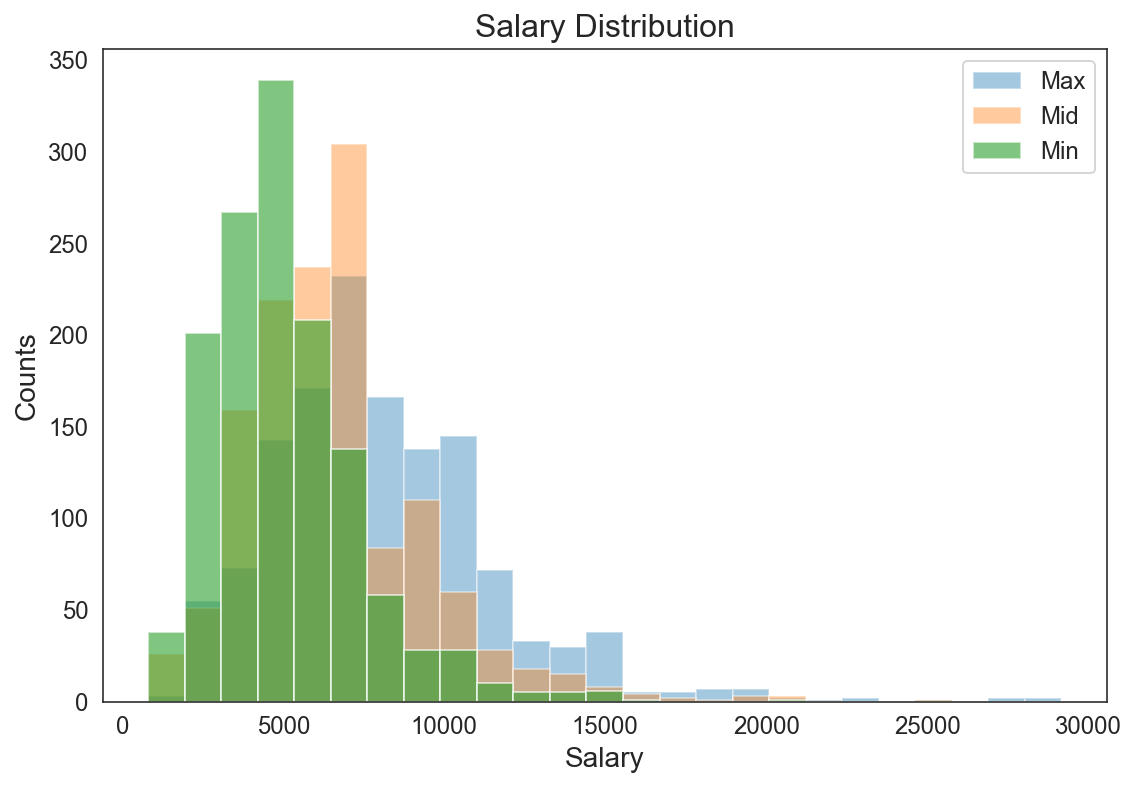

In [19]:
# check out salary distribution

bins = np.histogram(np.hstack((jobs['salary_min'],jobs['salary_mid'],jobs['salary_max'])), 
                    bins=25)[1]

fig, ax = plt.subplots(figsize=(9,6))

ax.hist(jobs['salary_max'],bins, label='Max', alpha=0.4)
ax.hist(jobs['salary_mid'],bins, label='Mid', alpha=0.4)
ax.hist(jobs['salary_min'],bins, label='Min', alpha=0.6)

plt.title('Salary Distribution', fontsize=16)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Salary', fontsize=14)
plt.ylabel('Counts', fontsize=14)

plt.show()

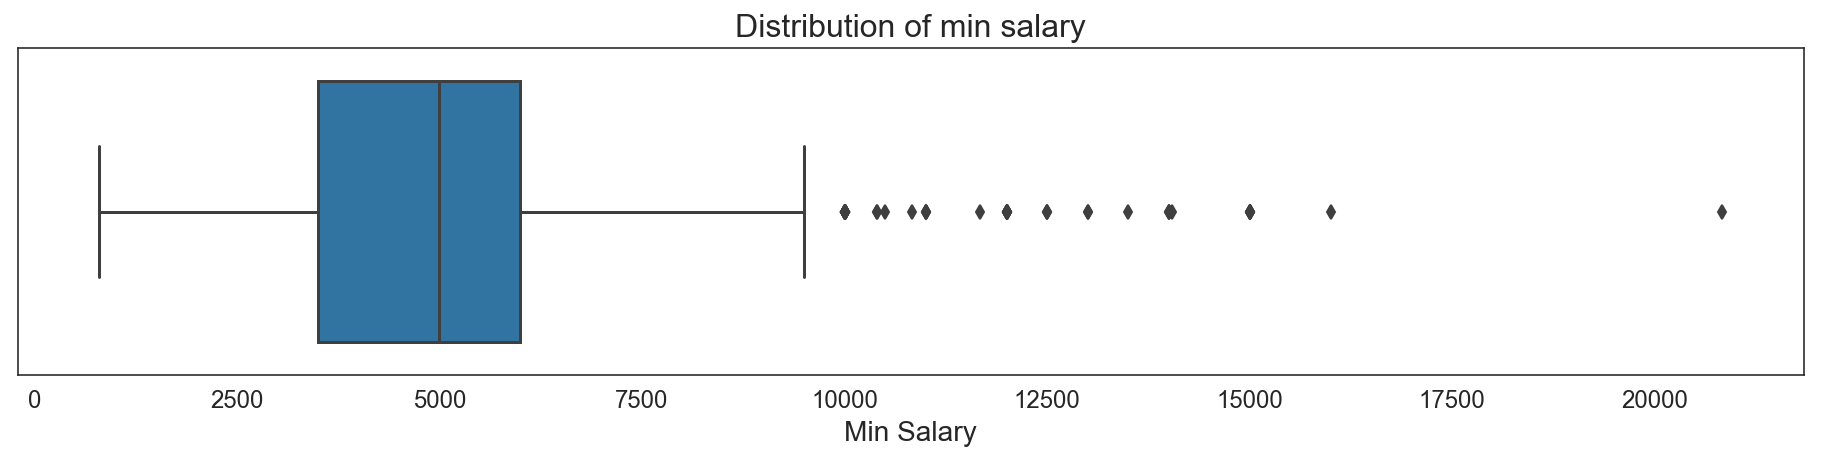

In [20]:
# taking a closer look at min distribution
fig, ax = plt.subplots(figsize=(16,3))

b = sns.boxplot(x='salary_min', data=jobs)
b.set_title('Distribution of min salary', fontsize=16)
b.set_xlabel('Min Salary', fontsize=14)
b.tick_params(labelsize=12)

plt.show()

In [21]:
def create_salary_labels_binary(salary):
    
    median = np.quantile(jobs['salary_min'],0.5)
    
    if salary < median: # low
        return 0
    elif salary >= median:
        return 1

In [22]:
jobs['salary_labels_binary'] = jobs['salary_min'].apply(lambda x: create_salary_labels_binary(x))

In [23]:
jobs['salary_labels_binary'].value_counts()

1    688
0    645
Name: salary_labels_binary, dtype: int64

#### 2.3 Cleaning up ```job_description```

In [24]:
# all job descriptions start with Roles and Responsibilities, so we can remove that
jobs[~jobs['job_description'].str.startswith('Roles & Responsibilities')]

,company,company_address,employment_type,job_category,job_description,job_requirements,job_title,salary_range,salary_type,seniority,url,search_query,salary_min,salary_max,salary_mid,monthly_vs_yearly,salary_labels_binary


In [25]:
jobs['job_description'] = jobs['job_description'].apply(lambda x: x[len('Roles & Responsibilities'):])

In [26]:
# # uncomment cell to check
# jobs.head(2)
# jobs.sample(2)['job_description'].values

#### 2.4 Cleaning up ```job_requirements```

In [27]:
# the only job requirements that don't start with Requirements are 'Unknown'
# i.e. a blank field when scraped from the website 
jobs[~jobs['job_requirements'].str.startswith('Requirements')]['job_requirements'].unique()

array(['Unknown'], dtype=object)

In [28]:
# for these jobs, the requirements were under the description section
jobs[~jobs['job_requirements'].str.startswith('Requirements')]['job_description'].values

array(['Responsibilities\nWorking closely with a team of experienced Researchers from multi-disciplinary backgrounds, you will play an integral part in the conceptualisation and execution of research projects related to public housing.\xa0\nYou will be part of a team to provide pertinent input and conduct analysis to complement/enhance the value of research projects.\xa0 Your responsibilities include compiling and analysing the demographic and socio-economic profile of residents, perform data analytics, statistical modelling on a wide array of data related to various aspects of public housing. \xa0You should have knowledge of suitable tools for data analytics, be able to derive insights from data and propose recommendations/solutions.\n\xa0\nRequirementsYou should possess a degree in Computer Science, Statistics, Applied Mathematics, Operation Research or equivalent technical field.\xa0 You should also have the versatility and ability to conduct independent research and be able to cont

In [29]:
# create a new column to flag for the rows that had job requirements as unknown
jobs['job_req_unknown'] = jobs['job_requirements'].apply(lambda x: 1 if x=='Unknown' else 0)

In [30]:
jobs.loc[jobs['job_req_unknown']==1].index

Int64Index([ 139,  357,  358,  365,  376,  382,  400,  401,  465,  552,  891,
             914, 1451, 1486, 1708, 1726, 1812],
           dtype='int64')

In [31]:
def clean_job_requirements_in_descriptions():

    req_unknown = jobs.loc[jobs['job_req_unknown']==1]
    
    for index in req_unknown.index:
        if 'Requirements' in jobs.loc[index]['job_description']:
            jobs.loc[index,'job_requirements'] = jobs.loc[index]['job_description'].split('Requirements')[1]
            jobs.loc[index,'job_description'] = jobs.loc[index]['job_description'].split('Requirements')[0]
        elif 'how to succeed:' in jobs.loc[index]['job_description'].lower():
            jobs.loc[index,'job_requirements'] = jobs.loc[index]['job_description'].lower().split('how to succeed:')[1]
            jobs.loc[index,'job_description'] = jobs.loc[index]['job_description'].lower().split('how to succeed:')[0] 
        else:
            jobs.loc[index,'job_requirements'] = 'Unknown'

clean_job_requirements_in_descriptions()

In [32]:
# # uncomment code to check:
# jobs[jobs['job_req_unknown']==1]

In [33]:
# print(jobs.loc[893]['job_requirements'])

In [34]:
# removing requirements from the start of every cell
jobs['job_requirements'] = jobs['job_requirements'].apply(lambda x: x[len('requirements'):] 
                                                          if x.startswith('Requirements') else x)

#### 2.5 Creating new column ```summary``` that combines ```job_description``` and ```job_requirements```

In [35]:
jobs['summary'] = jobs['job_description'] + ' ' + jobs['job_requirements']

#### 2.6 Handling categorical columns ```seniority```,  ```employment_type```, ```job_category```

For these columns:
- naming conventions are standardised (no typos or different spellings)
- but it is possible to have multiple categories per job, e.g. ```employment_type``` can be Full-Time and Contract or Full-Time and Permanent
- this creates many different combinations and it might not be feasible to create a dummy for every single combination

To resolve, dummy variables will be for each category in a feature, rather than for each combination of categories

#### Seniority

In [36]:
print('Total no. of seniority combinations: ', jobs['seniority'].nunique())
print('Sample of mixed categories:')
print(jobs[jobs['seniority'].str.contains(',')]['seniority'].sample().unique())

Total no. of seniority combinations:  53
Sample of mixed categories:
['Professional, Executive']


In [37]:
all_seniority = jobs['seniority'].unique()
all_seniority = list(itertools.chain.from_iterable([snr.split(',') for snr in all_seniority]))

all_seniority = [word.strip() for word in all_seniority]
all_seniority = set(all_seniority)

In [38]:
print('No. of seniority dummy features: ', len(all_seniority))
print(all_seniority)

No. of seniority dummy features:  10
{'Non-executive', 'Unknown', 'Professional', 'Manager', 'Fresh/entry level', 'Executive', 'Senior Management', 'Junior Executive', 'Senior Executive', 'Middle Management'}


In [39]:
for i in all_seniority:
    jobs['seniority_'+i] = jobs['seniority'].apply(lambda x: 1 if i in x.split(', ') else 0)

#### Job Category

In [40]:
print('Total no. of job category combinations: ', jobs['job_category'].nunique())
print('Sample of mixed categories:')
print(jobs[jobs['job_category'].str.contains(',')]['job_category'].sample().unique())

Total no. of job category combinations:  105
Sample of mixed categories:
['Design, Engineering, Others']


In [41]:
all_job_cats = jobs['job_category'].unique()
all_job_cats = list(itertools.chain.from_iterable([job_cat.split(',') for job_cat in all_job_cats]))

all_job_cats = [word.strip() for word in all_job_cats]
all_job_cats = set(all_job_cats)
print('No. of job category dummies: ', len(all_job_cats))

No. of job category dummies:  36


In [42]:
for i in all_job_cats:
    jobs['job_category_'+i] = jobs['job_category'].apply(lambda x: 1 if i in x.replace(' ,',',').split(', ') else 0)

#### Employment Type

In [43]:
print('Total no. of employment type combinations: ', jobs['employment_type'].nunique())
print('Sample of mixed categories:')
print(jobs[jobs['employment_type'].str.contains(',')]['employment_type'].sample().unique())

Total no. of employment type combinations:  15
Sample of mixed categories:
['Permanent, Full Time']


In [44]:
all_emp_types = jobs['employment_type'].unique()
all_emp_types = list(itertools.chain.from_iterable([emp_type.split(',') for emp_type in all_emp_types]))

all_emp_types = [word.strip() for word in all_emp_types]
all_emp_types = set(all_emp_types)

print('No. of employment type dummies: ', len(all_emp_types))

No. of employment type dummies:  8


In [45]:
for i in all_emp_types:
    jobs['employment_type_'+i] = jobs['employment_type'].apply(lambda x: 1 if i in x.split(', ') else 0)

### 3. Text Preprocessing

In [46]:
# nltk.download('averaged_perceptron_tagger')

#### 3.1 Extending stopwords
- this is to exclude words common to this domain that add little context/meaning when trying to predict salaries

In [47]:
stoplist = list(stop_words.ENGLISH_STOP_WORDS)

print('No. of stopwords before extending: ', len(stoplist))

stoplist.extend(['requirement', 'candidate', 'shortlist', 'regret', 'notify', 'pte', 'ltd', 'private', 'limited',
                 'company', 'undisclosed', 'responsibility', 'require', 'ability', 'work', 'closely', 'time', 
                 'criterion', 'recruitment', 'visit', 'www', 'star', 'edu', 'sg', 'amend', 'notice', 'include', 
                 'additional', 'selection', 'base', 'eligibility', 'short'])
print('No. of stopwords after extending: ', len(stoplist))

No. of stopwords before extending:  318
No. of stopwords after extending:  350


In [48]:
def text_preprocessing(df, column_name):
    
    # remove special characters
    df[column_name+'_cleaned'] = df[column_name].apply(lambda x: str(x.encode('ascii', errors='ignore'))[2:])

    # change to lower case
    df[column_name+'_cleaned'] = df[column_name+'_cleaned'].apply(lambda x: ' '.join(x.lower() for x in x.split()))

    # remove punctuation, replace with space
    df[column_name+'_cleaned'] = df[column_name+'_cleaned'].str.replace('[^\w\s]', ' ')

    # remove numbers
    df[column_name+'_cleaned'] = df[column_name+'_cleaned'].apply(lambda x: ''.join(
        [c for c in x if not c.isdigit()]))

    # stop words
    stop = stopwords.words('english')
    df[column_name+'_cleaned'] = df[column_name+'_cleaned'].apply(lambda x: ' '.join(x for x in x.split() if x not in stop))

    # lemmatize
    pos_lookup={'JJ':'a', 'JJR':'a', 'JJS':'a', 'RB':'r', 'RBR':'r', 'RBS':'r', 'VB':'v', 'VBD':'v', 
                'VBG':'v', 'VBN':'v', 'VBP':'v', 'VBZ':'v', 'NN':'n', 'NNS':'n', 'NNP':'n', 'NNPS':'n', 
                'n':'n', 'a':'a', 'r':'r', 'v':'v', 's':'s'}
    df[column_name+'_cleaned'] = df[column_name+'_cleaned'].apply(lambda x: 
                                                                  ' '.join([(Word(word).lemmatize(pos_lookup.get(tag))) 
                                                                            for word, tag in TextBlob(x).tags]))

In [49]:
text_preprocessing(jobs, 'job_description')
text_preprocessing(jobs, 'job_requirements')
text_preprocessing(jobs, 'job_title')
text_preprocessing(jobs, 'employment_type')
text_preprocessing(jobs, 'job_category')
text_preprocessing(jobs, 'seniority')
text_preprocessing(jobs, 'summary')

### 4. EDA & Feature Engineering

#### 4.1 Distribution of dataset

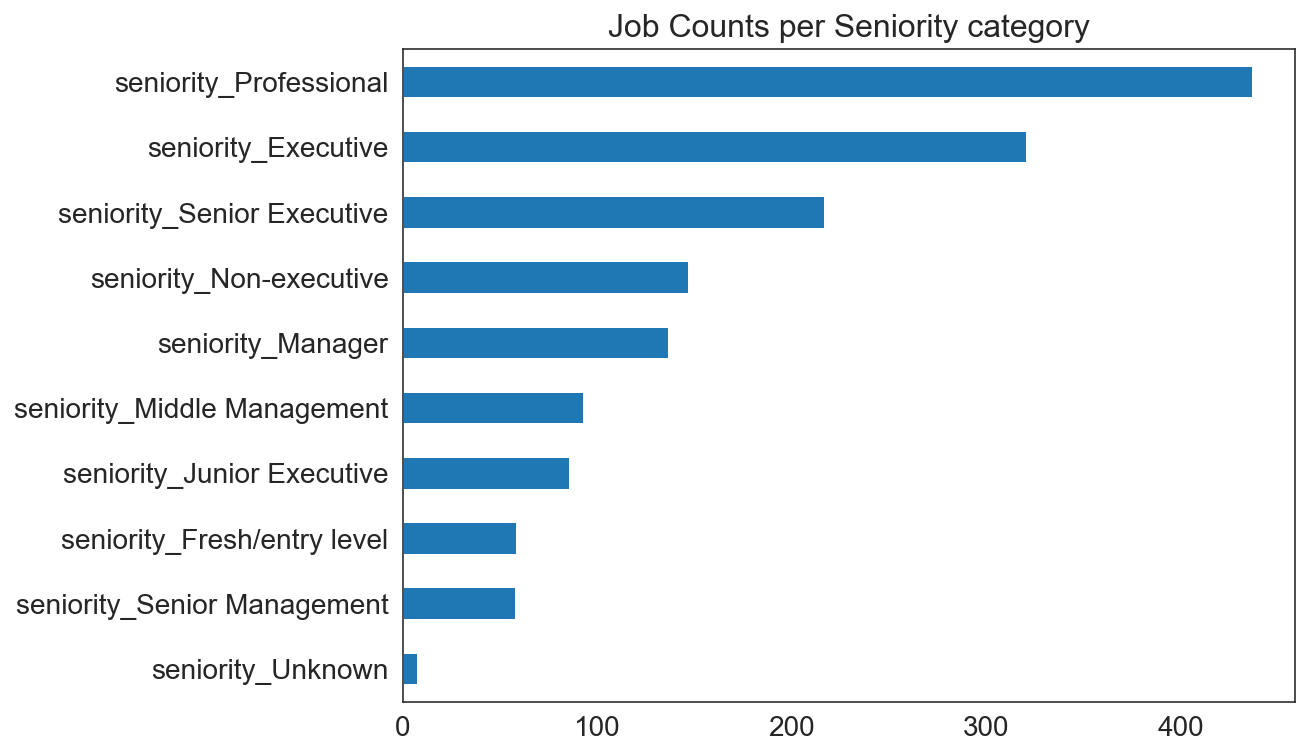

In [50]:
plt.figure(figsize=(8, 6))

jobs[['seniority_Unknown',
       'seniority_Middle Management', 'seniority_Senior Executive',
       'seniority_Professional', 'seniority_Executive',
       'seniority_Senior Management', 'seniority_Junior Executive',
       'seniority_Non-executive', 'seniority_Manager',
       'seniority_Fresh/entry level']].sum().sort_values().plot(kind='barh', color='C0')

plt.title('Job Counts per Seniority category', fontsize=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

plt.show()

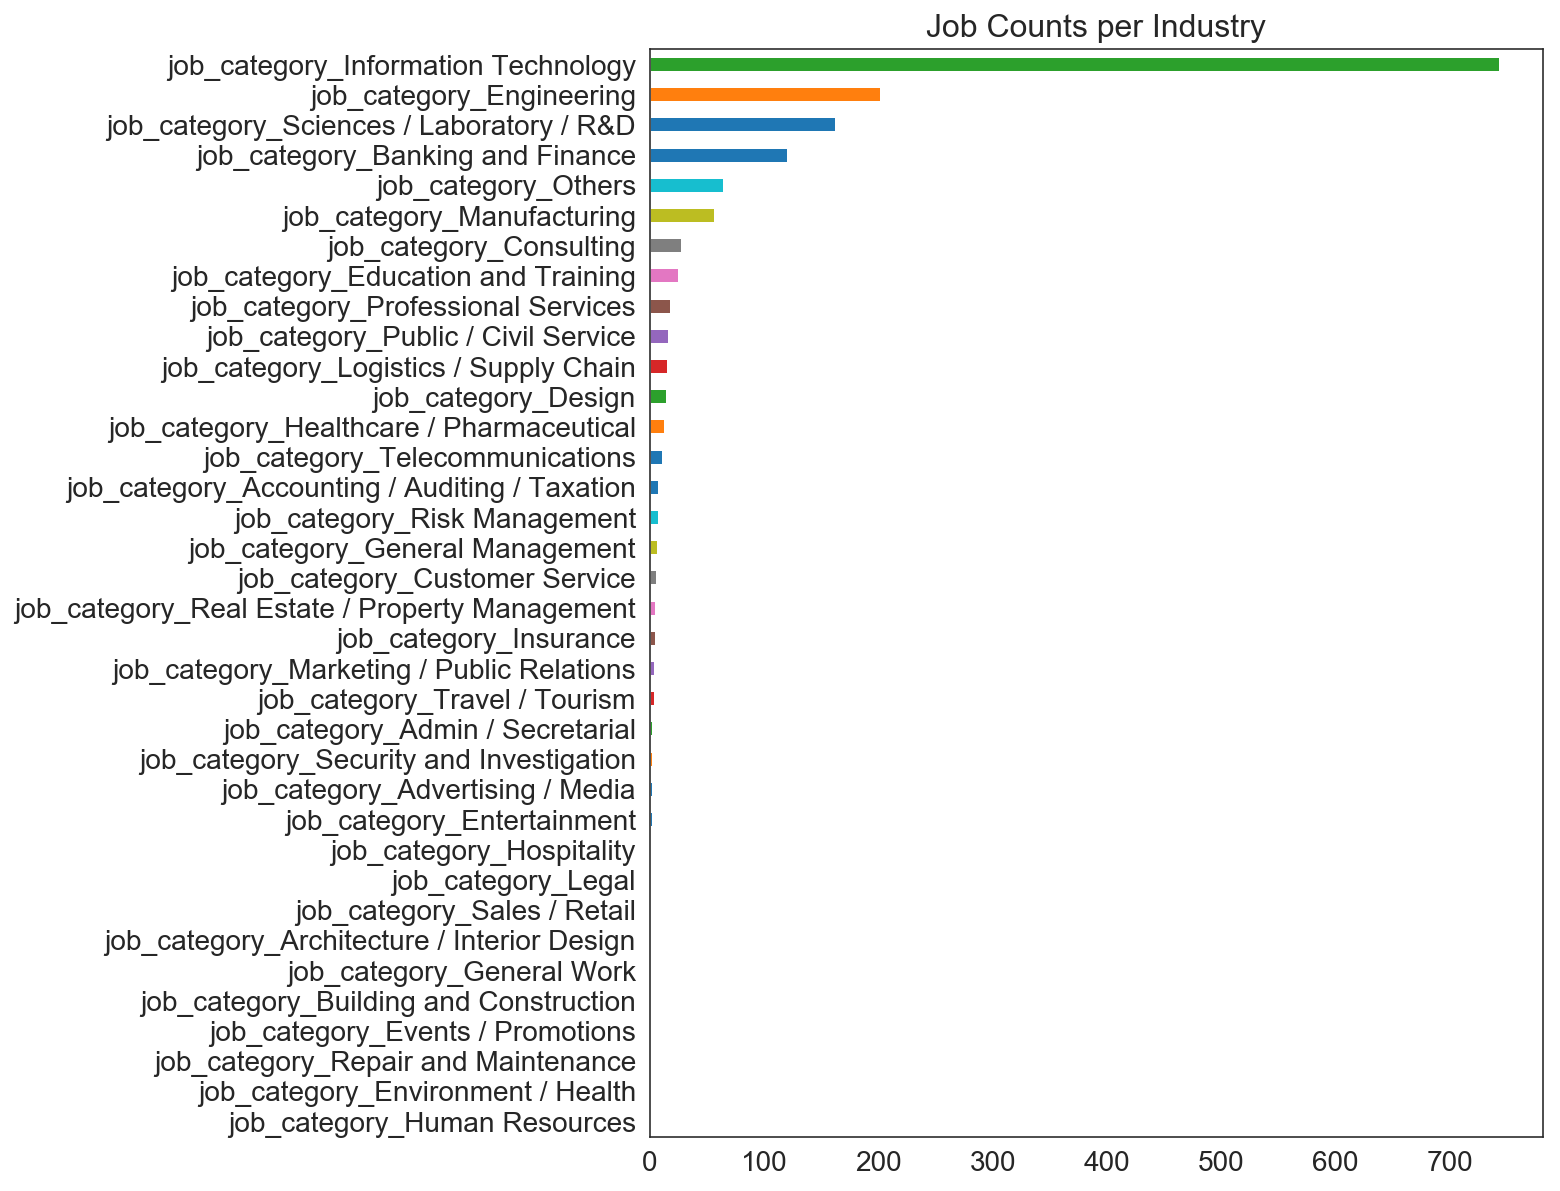

In [51]:
plt.figure(figsize=(8, 10))

jobs[['job_category_Public / Civil Service',
       'job_category_General Management', 'job_category_Legal',
       'job_category_Marketing / Public Relations',
       'job_category_Admin / Secretarial', 'job_category_Manufacturing',
       'job_category_Environment / Health', 'job_category_Human Resources',
       'job_category_Information Technology', 'job_category_Insurance',
       'job_category_Logistics / Supply Chain',
       'job_category_Advertising / Media', 'job_category_Risk Management',
       'job_category_Travel / Tourism', 'job_category_Others',
       'job_category_Security and Investigation',
       'job_category_Telecommunications',
       'job_category_Repair and Maintenance', 'job_category_Hospitality',
       'job_category_General Work', 'job_category_Consulting',
       'job_category_Building and Construction', 'job_category_Entertainment',
       'job_category_Professional Services', 'job_category_Design',
       'job_category_Events / Promotions',
       'job_category_Accounting / Auditing / Taxation',
       'job_category_Education and Training', 'job_category_Customer Service',
       'job_category_Engineering', 'job_category_Healthcare / Pharmaceutical',
       'job_category_Real Estate / Property Management',
       'job_category_Sciences / Laboratory / R&D',
       'job_category_Banking and Finance',
       'job_category_Architecture / Interior Design',
       'job_category_Sales / Retail']].sum().sort_values().plot(kind='barh')

plt.title('Job Counts per Industry', fontsize=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

plt.show()

#### ```summary```: visualising differences between high and low salaries

In [52]:
tfidf = TfidfVectorizer(strip_accents='ascii', stop_words=stoplist, ngram_range=(2,3))

low_summary = tfidf.fit_transform(jobs[jobs['salary_labels_binary']==0]['summary_cleaned'])
low_summary = pd.DataFrame(low_summary.todense(), columns=tfidf.get_feature_names())
low_summary = low_summary.sum().sort_values()

high_summary = tfidf.fit_transform(jobs[jobs['salary_labels_binary']==1]['summary_cleaned'])
high_summary = pd.DataFrame(high_summary.todense(), columns=tfidf.get_feature_names())
high_summary = high_summary.sum().sort_values()

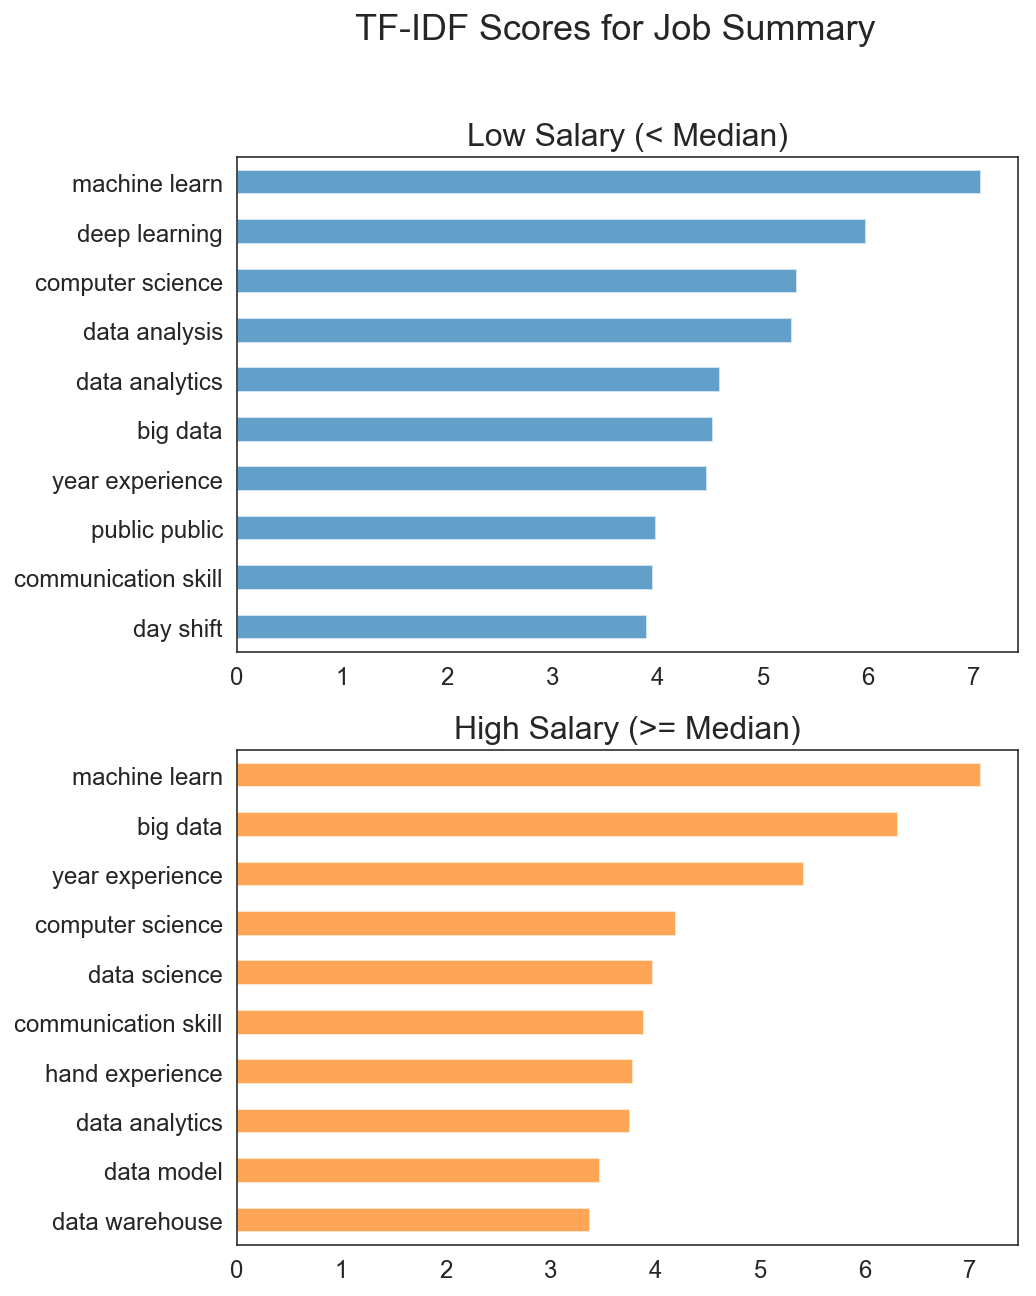

In [53]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7,10))

low_summary[-10:].plot(kind='barh', ax=axes[0], fontsize=12, color='C0', alpha=0.7)
high_summary[-10:].plot(kind='barh', ax=axes[1], fontsize=12, color='C1', alpha=0.7)

plt.suptitle('TF-IDF Scores for Job Summary', fontsize=18)

axes[0].set_title('Low Salary (< Median)', fontsize=16)
axes[1].set_title('High Salary (>= Median)', fontsize=16)

plt.show()

#### Job Title

In [54]:
cvec = CountVectorizer(strip_accents='ascii', stop_words='english', ngram_range=(2,2))

low_title = cvec.fit_transform(jobs[jobs['salary_labels_binary']==0]['job_title_cleaned'])
low_title = pd.DataFrame(low_title.todense(), columns=cvec.get_feature_names())
low_title = low_title.sum().sort_values()

high_title = cvec.fit_transform(jobs[jobs['salary_labels_binary']==1]['job_title_cleaned'])
high_title = pd.DataFrame(high_title.todense(), columns=cvec.get_feature_names())
high_title = high_title.sum().sort_values()

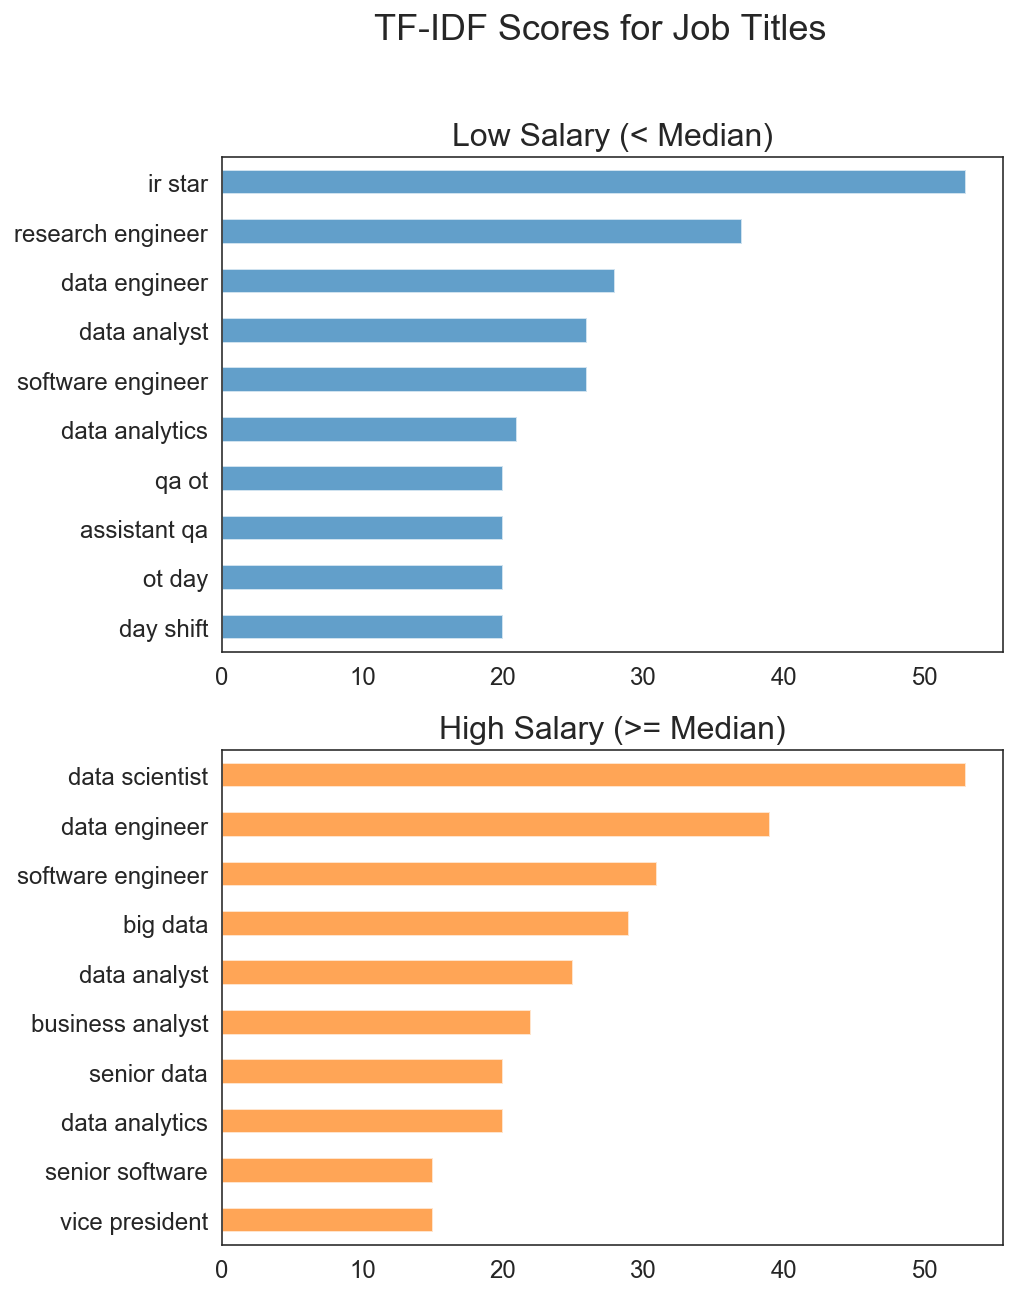

In [55]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7,10))

low_title[-10:].plot(kind='barh', ax=axes[0], fontsize=12, color='C0', alpha=0.7)
high_title[-10:].plot(kind='barh', ax=axes[1], fontsize=12, color='C1', alpha=0.7)

plt.suptitle('TF-IDF Scores for Job Titles', fontsize=18)

axes[0].set_title('Low Salary (< Median)', fontsize=16)
axes[1].set_title('High Salary (>= Median)', fontsize=16)

plt.show()

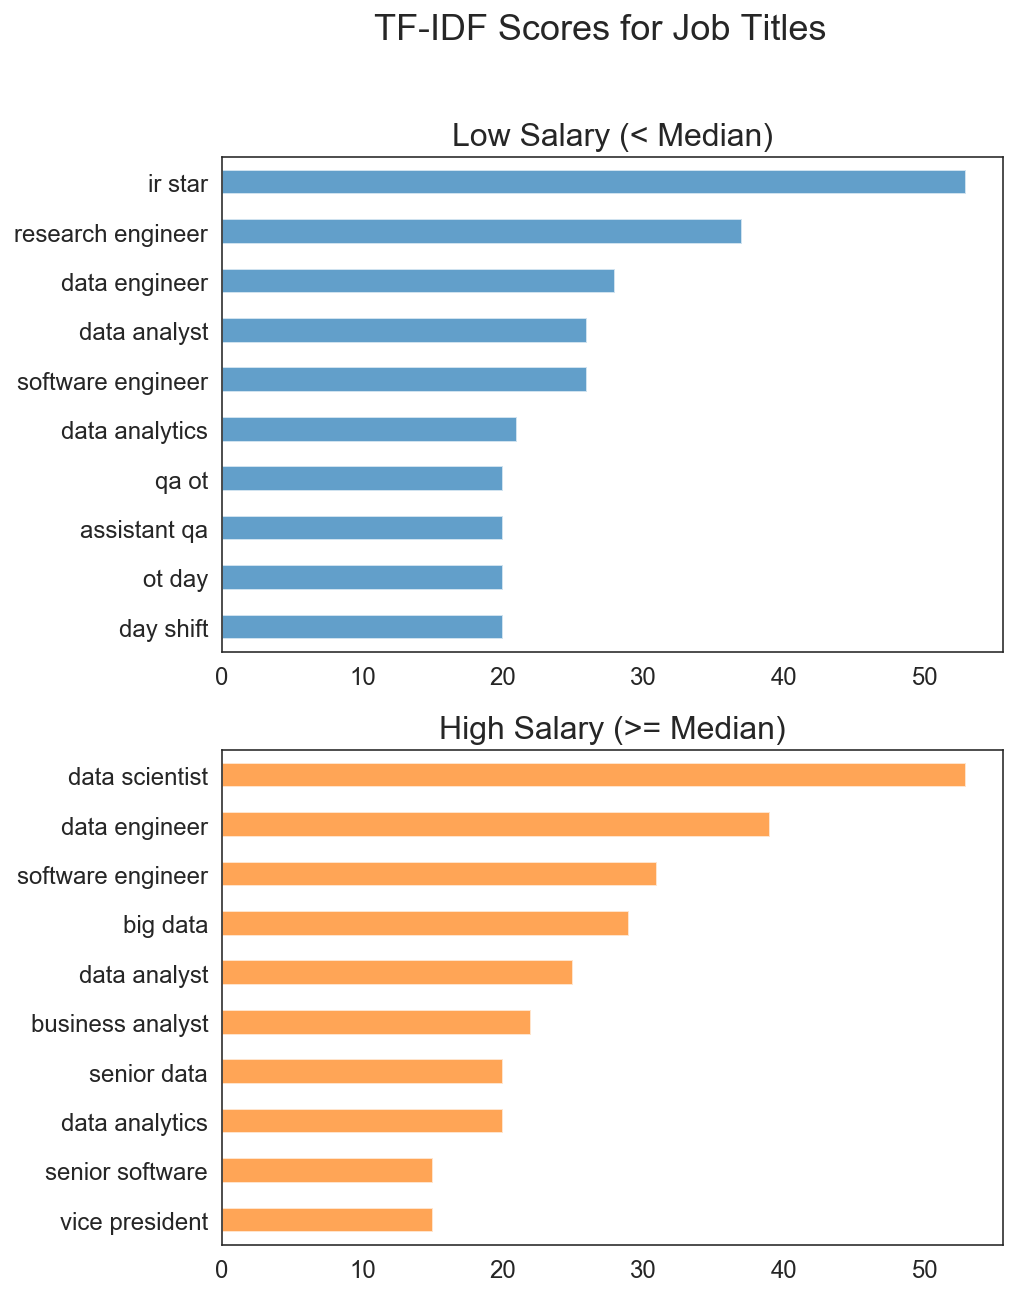

In [56]:
cvec = CountVectorizer(strip_accents='ascii', stop_words='english', ngram_range=(2,2))

low_title = cvec.fit_transform(jobs[jobs['salary_labels_binary']==0]['job_title_cleaned'])
low_title = pd.DataFrame(low_title.todense(), columns=cvec.get_feature_names())
low_title = low_title.sum().sort_values()

high_title = cvec.fit_transform(jobs[jobs['salary_labels_binary']==1]['job_title_cleaned'])
high_title = pd.DataFrame(high_title.todense(), columns=cvec.get_feature_names())
high_title = high_title.sum().sort_values()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7,10))

low_title[-10:].plot(kind='barh', ax=axes[0], fontsize=12, color='C0', alpha=0.7)
high_title[-10:].plot(kind='barh', ax=axes[1], fontsize=12, color='C1', alpha=0.7)

plt.suptitle('TF-IDF Scores for Job Titles', fontsize=18)

axes[0].set_title('Low Salary (< Median)', fontsize=16)
axes[1].set_title('High Salary (>= Median)', fontsize=16)

plt.show()

#### Company
It seems research roles in universities tend to have lower than median salaries, while banks, consultancies and tech firms have a higher salary

In [57]:
tfidf = TfidfVectorizer(strip_accents='ascii', stop_words=stoplist, ngram_range=(2,2))

low_company = tfidf.fit_transform(jobs[jobs['salary_labels_binary']==0]['company'])
low_company = pd.DataFrame(low_company.todense(), columns=tfidf.get_feature_names())
low_company = low_company.sum().sort_values()

high_company = tfidf.fit_transform(jobs[jobs['salary_labels_binary']==1]['company'])
high_company = pd.DataFrame(high_company.todense(), columns=tfidf.get_feature_names())
high_company = high_company.sum().sort_values()

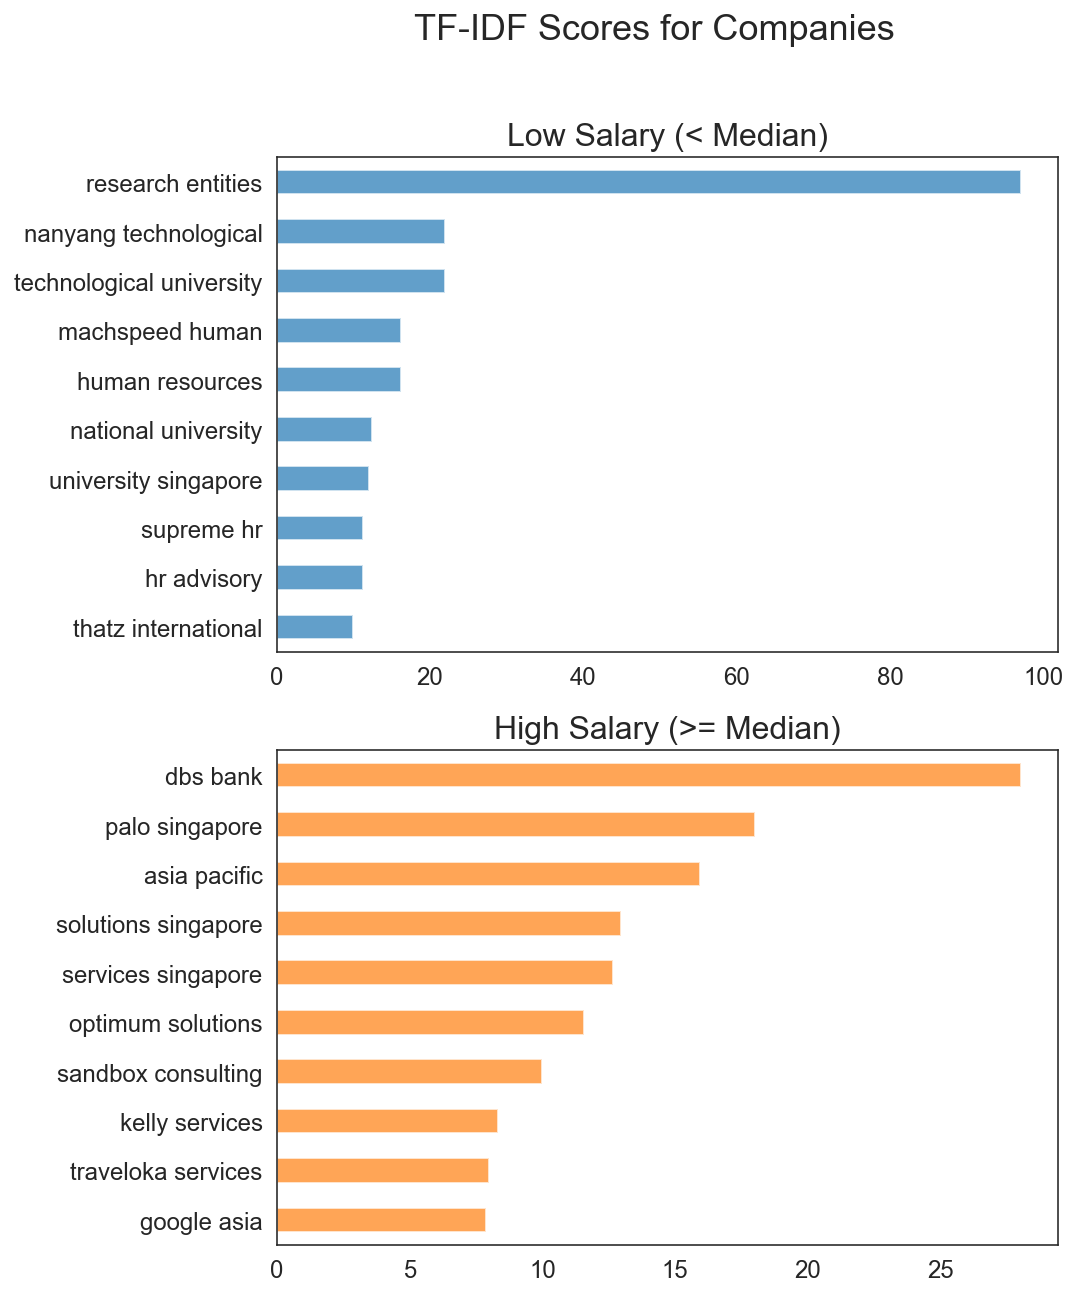

In [58]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7,10))

low_company[-10:].plot(kind='barh', ax=axes[0], fontsize=12, color='C0', alpha=0.7)
high_company[-10:].plot(kind='barh', ax=axes[1], fontsize=12, color='C1', alpha=0.7)

plt.suptitle('TF-IDF Scores for Companies', fontsize=18)

axes[0].set_title('Low Salary (< Median)', fontsize=16)
axes[1].set_title('High Salary (>= Median)', fontsize=16)

plt.show()

### 5. Modelling

In [59]:
jobs = jobs.reset_index(drop=True)

In [60]:
jobs.shape

(1333, 80)

In [61]:
jobs.head(2)

,company,company_address,employment_type,job_category,job_description,job_requirements,job_title,salary_range,salary_type,seniority,...,employment_type_Part Time,employment_type_Permanent,employment_type_Flexi work,job_description_cleaned,job_requirements_cleaned,job_title_cleaned,employment_type_cleaned,job_category_cleaned,seniority_cleaned,summary_cleaned
0,MONEYSMART SINGAPORE PTE. LTD.,"GRANDE BUILDING, 8 COMMONWEALTH LANE 149555",Permanent,Information Technology,About the job Moneysmart is hiring a Data Team...,Requirements 6+ years of professional experie...,Data Team Lead,"$8,000to$140,000",Monthly,Manager,...,0,1,0,job moneysmart hire data team lead help lead t...,requirement year professional experience build...,data team lead,permanent,information technology,manager,job moneysmart hire data team lead help lead t...
1,CAPGEMINI SINGAPORE PTE. LTD.,6 BATTERY ROAD 049909,"Permanent, Contract",Information Technology,Work with stakeholders to understand the bu...,Flexible to do a contractual role Experience ...,Data Scientist,"$7,000to$10,000",Monthly,Professional,...,0,1,0,work stakeholder understand business use case ...,flexible contractual role experience use compu...,data scientist,permanent contract,information technology,professional,work stakeholder understand business use case ...


#### 5.1 Get baseline

Baseline is 51% - meaning that if I were to simply predict high salary, I would get an accuracy score of 51%. A score lower than this means that it is performing worse than if the model were to just predict a high salary for everything

In [62]:
jobs['salary_labels_binary'].value_counts()/len(jobs)

1    0.516129
0    0.483871
Name: salary_labels_binary, dtype: float64

#### 5.2 Model 1: Few features, without using text data
- Predictor Variables: ```employment_type```, ```job_category```, ```seniority```, ```search_query```
- First model was pretty good given that it had minimal processing! 
- It achieved a test score of 76.8% accuracy, although the cross val score fared slighly poorer.
- However, the False Positives is pretty high. Implication: the model is predicting a high salary when in fact it is a low salary pretty often. This is not ideal for the business as we wouldn't want to be telling customers that a job is offering a high salary when it in fact isn't

In [63]:
X = jobs[['job_category', 'seniority', 'employment_type', 'search_query']]
y = jobs['salary_labels_binary']

print(X.shape)
print(y.shape)
X.head(2)

(1333, 4)
(1333,)


,job_category,seniority,employment_type,search_query
0,Information Technology,Manager,Permanent,data_architect
1,Information Technology,Professional,"Permanent, Contract",data_architect


In [64]:
X_dummies = pd.get_dummies(X)

print(X_dummies.shape)
X_dummies.columns[:5]

(1333, 186)


Index(['job_category_Accounting / Auditing / Taxation',
       'job_category_Accounting / Auditing / Taxation, Banking and Finance',
       'job_category_Accounting / Auditing / Taxation, Information Technology',
       'job_category_Accounting / Auditing / Taxation, Risk Management, Legal',
       'job_category_Admin / Secretarial'],
      dtype='object')

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size=0.3, random_state=123, stratify=y)

In [66]:
rf = RandomForestClassifier(n_estimators=500)

rf_cv_scores = cross_val_score(rf, X_train, y_train, cv=10, scoring='accuracy')

rf.fit(X_train, y_train)
preds = rf.predict(X_test)

confusion_mat = pd.crosstab(y_test,preds,
                            rownames=['Actual'],
                            colnames=['Predicted'],margins=True)

y_pp = pd.DataFrame(rf.predict_proba(X_test), columns=['class_0_pp', 'class_1_pp'])

print('----- Scores -----')
print('CV Score (Accuracy): {:.3f} ± {:.3f}'.format(rf_cv_scores.mean(), rf_cv_scores.std()))
print('Test Score (Accuracy): ',rf.score(X_test,y_test))
print('\n----- Confusion Matrix -----')
print(confusion_mat)
print('\n----- Classification Report -----')
print(classification_report(y_test, preds))

----- Scores -----
CV Score (Accuracy): 0.738 ± 0.045
Test Score (Accuracy):  0.77

----- Confusion Matrix -----
Predicted    0    1  All
Actual                  
0          141   53  194
1           39  167  206
All        180  220  400

----- Classification Report -----
              precision    recall  f1-score   support

           0       0.78      0.73      0.75       194
           1       0.76      0.81      0.78       206

   micro avg       0.77      0.77      0.77       400
   macro avg       0.77      0.77      0.77       400
weighted avg       0.77      0.77      0.77       400



In [67]:
fi = pd.DataFrame(rf.feature_importances_, index=X_train.columns)
fi.rename(columns={0:'Feature Importance'},inplace=True)
fi.sort_values(by=['Feature Importance'], ascending=False, inplace=True)
fi.head(10)

,Feature Importance
job_category_Sciences / Laboratory / R&D,0.054056
job_category_Information Technology,0.052779
"employment_type_Contract, Full Time",0.040553
search_query_data_analysis,0.035214
seniority_Professional,0.033498
employment_type_Full Time,0.033494
search_query_sql,0.031074
employment_type_Permanent,0.029044
seniority_Executive,0.028083
seniority_Fresh/entry level,0.026788


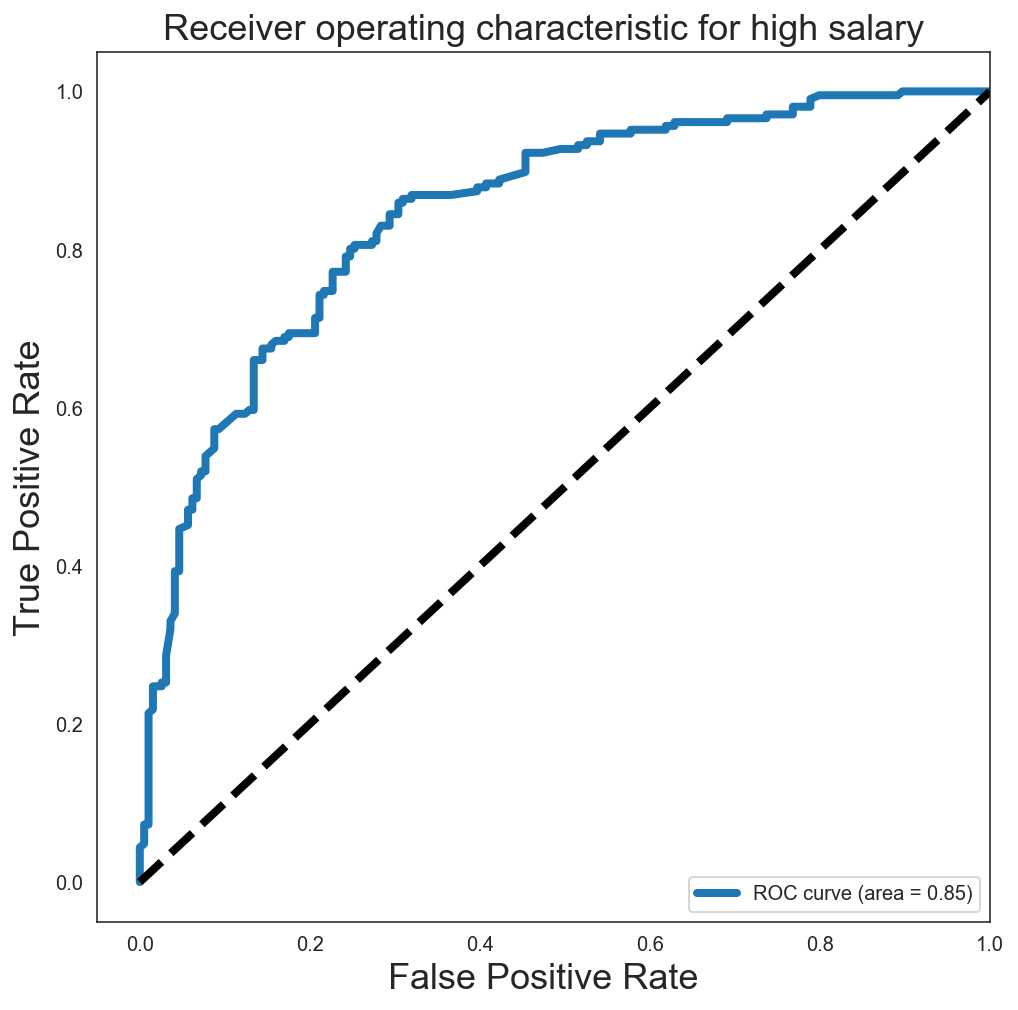

In [68]:
# Plotting ROC curve for high salary (Class 1)
fpr, tpr, thresholds = roc_curve(y_test, y_pp['class_1_pp'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for high salary', fontsize=18)
plt.legend(loc="lower right")
plt.show()

#### 5.3 Above 4 features, but using the processed dummies
- No significance difference. CV Scores are lower, but test scores are higher
- Will take the processed dummies as the features are categorized better.
- False positives also went down from 55 to 52

In [69]:
X = jobs.drop(['company', 'company_address', 'employment_type', 'job_category', 'job_description', 'job_requirements', 'job_title', 
               'salary_range', 'salary_type', 'seniority', 'url', 'salary_min', 'salary_max', 'salary_mid', 
               'monthly_vs_yearly', 'salary_labels_binary', 'job_req_unknown', 'summary','job_description_cleaned',
               'job_requirements_cleaned', 'job_title_cleaned', 'employment_type_cleaned', 'job_category_cleaned', 
               'seniority_cleaned', 'summary_cleaned'], axis=1)
y = jobs['salary_labels_binary']

X_dummies = pd.get_dummies(X['search_query'])
X = pd.concat([X, X_dummies], axis=1).drop('search_query', axis=1)

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)

In [71]:
rf = RandomForestClassifier(n_estimators=500)

rf_cv_scores = cross_val_score(rf, X_train, y_train, cv=10, scoring='accuracy')

rf.fit(X_train, y_train)
preds = rf.predict(X_test)

confusion_mat = pd.crosstab(y_test,preds,
                            rownames=['Actual'],
                            colnames=['Predicted'],margins=True)

y_pp = pd.DataFrame(rf.predict_proba(X_test), columns=['class_0_pp', 'class_1_pp'])

print('----- Scores -----')
print('CV Score (Accuracy): {:.3f} ± {:.3f}'.format(rf_cv_scores.mean(), rf_cv_scores.std()))
print('Test Score (Accuracy): ',rf.score(X_test,y_test))
print('\n----- Confusion Matrix -----')
print(confusion_mat)
print('\n----- Classification Report -----')
print(classification_report(y_test, preds))

----- Scores -----
CV Score (Accuracy): 0.723 ± 0.051
Test Score (Accuracy):  0.7775

----- Confusion Matrix -----
Predicted    0    1  All
Actual                  
0          142   52  194
1           37  169  206
All        179  221  400

----- Classification Report -----
              precision    recall  f1-score   support

           0       0.79      0.73      0.76       194
           1       0.76      0.82      0.79       206

   micro avg       0.78      0.78      0.78       400
   macro avg       0.78      0.78      0.78       400
weighted avg       0.78      0.78      0.78       400



In [72]:
fi = pd.DataFrame(rf.feature_importances_, index=X_train.columns)
fi.rename(columns={0:'Feature Importance'},inplace=True)
fi.sort_values(by=['Feature Importance'], ascending=False, inplace=True)
fi.head(10)

,Feature Importance
job_category_Sciences / Laboratory / R&D,0.069750
job_category_Information Technology,0.064819
employment_type_Contract,0.048745
employment_type_Permanent,0.045207
employment_type_Full Time,0.043625
seniority_Executive,0.040927
seniority_Professional,0.040090
seniority_Junior Executive,0.038841
seniority_Fresh/entry level,0.037611
seniority_Senior Executive,0.036849


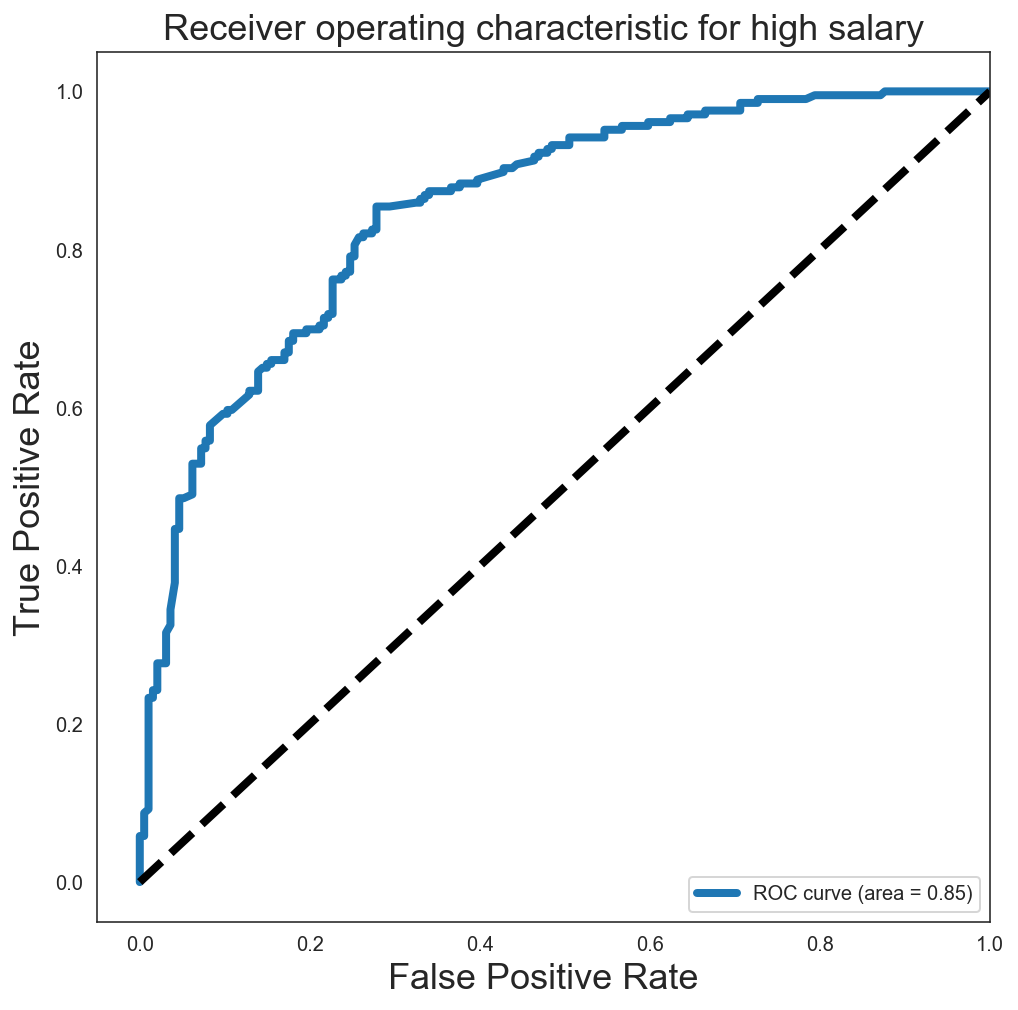

In [73]:
# Plotting ROC curve for high salary (Class 1)
fpr, tpr, thresholds = roc_curve(y_test, y_pp['class_1_pp'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for high salary', fontsize=18)
plt.legend(loc="lower right")
plt.show()

#### 5.4 Try Naive Bayes
Not too bad, scores are also pretty close, but faring worse on False Positives

In [74]:
mnb = MultinomialNB()

mnb_cv_scores = cross_val_score(mnb, X_train, y_train, cv=10, scoring='accuracy')

mnb.fit(X_train, y_train)
preds = mnb.predict(X_test)

confusion_mat = pd.crosstab(y_test,preds,
                            rownames=['Actual'],
                            colnames=['Predicted'],margins=True)

y_pp = pd.DataFrame(mnb.predict_proba(X_test), columns=['class_0_pp', 'class_1_pp'])

print('----- Scores -----')
print('CV Score (Accuracy): {:.3f} ± {:.3f}'.format(mnb_cv_scores.mean(), mnb_cv_scores.std()))
print('Test Score (Accuracy): ',mnb.score(X_test,y_test))
print('\n----- Confusion Matrix -----')
print(confusion_mat)
print('\n----- Classification Report -----')
print(classification_report(y_test, preds))

----- Scores -----
CV Score (Accuracy): 0.718 ± 0.025
Test Score (Accuracy):  0.755

----- Confusion Matrix -----
Predicted    0    1  All
Actual                  
0          133   61  194
1           37  169  206
All        170  230  400

----- Classification Report -----
              precision    recall  f1-score   support

           0       0.78      0.69      0.73       194
           1       0.73      0.82      0.78       206

   micro avg       0.76      0.76      0.76       400
   macro avg       0.76      0.75      0.75       400
weighted avg       0.76      0.76      0.75       400



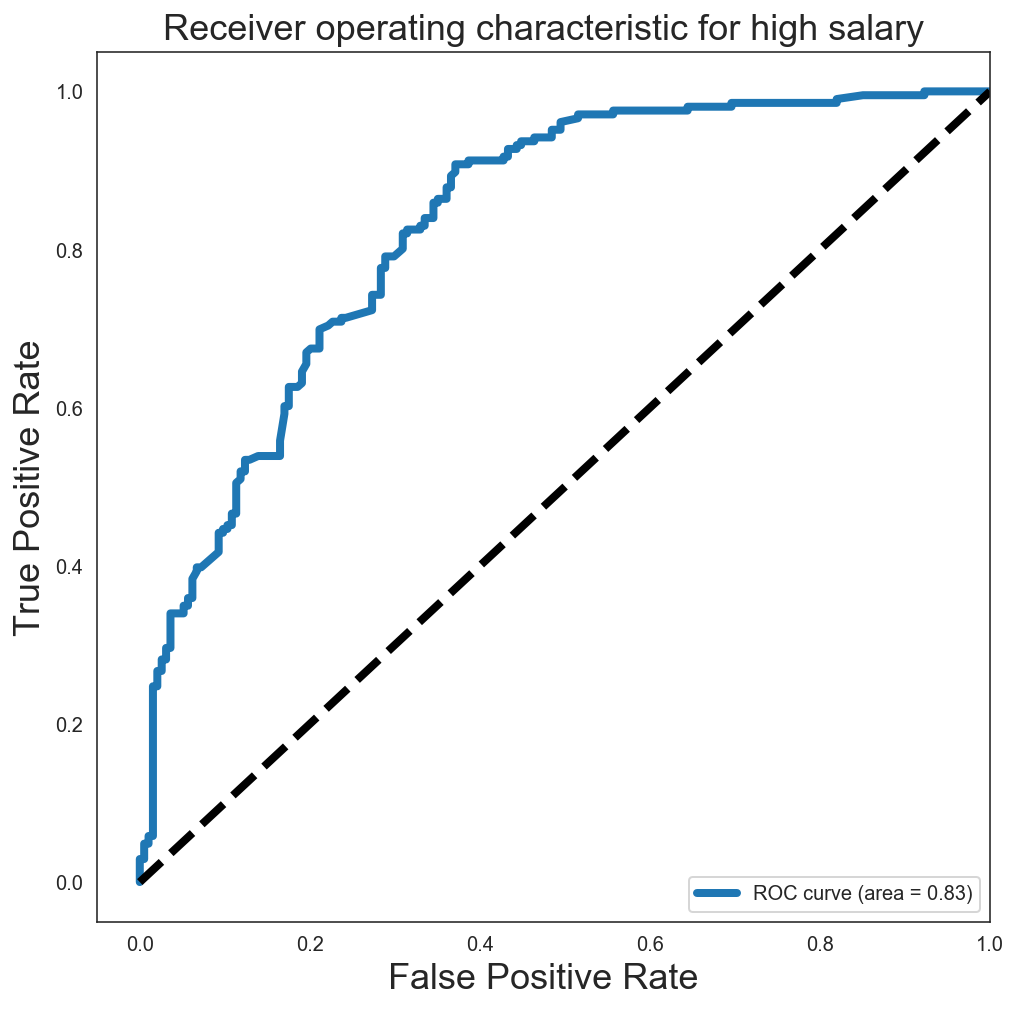

In [75]:
# Plotting ROC curve for high salary (Class 1)
fpr, tpr, thresholds = roc_curve(y_test, y_pp['class_1_pp'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for high salary', fontsize=18)
plt.legend(loc="lower right")
plt.show()

#### 5.5 Categorical + Job Title + Job Requirements
- Scores are about the same, but False positivies deproved by a lot
- 80 out of 114 low salaries were misclassified by the model

In [76]:
X = jobs.drop(['company', 'company_address', 'employment_type', 'job_category', 'job_description', 'job_requirements', 
               'job_title', 'salary_range', 'salary_type', 'seniority', 'url', 'search_query', 'salary_min', 
               'salary_max', 'salary_mid', 'monthly_vs_yearly', 'salary_labels_binary', 'job_req_unknown', 
               'job_description_cleaned', 'employment_type_cleaned', 'summary', 'summary_cleaned',
               'job_category_cleaned', 'seniority_cleaned'], axis=1)
y = jobs['salary_labels_binary']

In [77]:
tfidf = TfidfVectorizer(stop_words=stoplist,
                        ngram_range=(2,2), 
                        strip_accents='ascii', 
                        min_df=1, 
                        max_df=0.9)

JR = tfidf.fit_transform(X['job_requirements_cleaned'])
JR = pd.DataFrame(JR.todense(), columns=['JR_'+column for column in tfidf.get_feature_names()])

cvec = CountVectorizer(stop_words='english',
                        ngram_range=(2,2), 
                        strip_accents='ascii', 
                        min_df=1, 
                        max_df=1.0)

JT = cvec.fit_transform(X['job_title_cleaned'])
JT = pd.DataFrame(JT.todense(), columns=['JT_'+column for column in cvec.get_feature_names()])

X = pd.concat([X.drop(['job_requirements_cleaned','job_title_cleaned'], axis=1), JR, JT], axis=1)

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)

In [79]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(933, 45318)
(400, 45318)
(933,)
(400,)


In [80]:
rf = RandomForestClassifier(n_estimators=200)

rf_cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')

rf.fit(X_train, y_train)
preds = rf.predict(X_test)

confusion_mat = pd.crosstab(y_test,preds,
                            rownames=['Actual'],
                            colnames=['Predicted'],margins=True)

print(rf_cv_scores)
print(rf.score(X_test,y_test))
print('Accuracy Score: ', accuracy_score(y_test, preds))
print('ROC: ', roc_auc_score(y_test, preds))
print('\n')
print(confusion_mat)
print('\n')
print(classification_report(y_test, preds))
print('\n')
fi = pd.DataFrame(rf.feature_importances_, index=X_train.columns)
fi.rename(columns={0:'Importance'},inplace=True)
fi.sort_values(by=['Importance'], ascending=False, inplace=True)
fi.head(10)

[0.7606383  0.7540107  0.79569892 0.73655914 0.74731183]
0.77
Accuracy Score:  0.77
ROC:  0.7649884896406767


Predicted    0    1  All
Actual                  
0          116   78  194
1           14  192  206
All        130  270  400


              precision    recall  f1-score   support

           0       0.89      0.60      0.72       194
           1       0.71      0.93      0.81       206

   micro avg       0.77      0.77      0.77       400
   macro avg       0.80      0.76      0.76       400
weighted avg       0.80      0.77      0.76       400





,Importance
job_category_Sciences / Laboratory / R&D,0.011199
seniority_Fresh/entry level,0.008028
seniority_Junior Executive,0.007257
JR_policy policy,0.006414
seniority_Manager,0.006072
seniority_Non-executive,0.005450
JR_exhaustive prevail,0.005266
JR_prevail policy,0.005158
job_category_Information Technology,0.004704
JR_team player,0.004397


#### 5.6 FINAL MODEL:  Categorical + Job Title + Summary + Company
- Also changing test set to be 20% to increase training data

In [81]:
X = jobs.drop(['company_address', 'employment_type', 'job_category', 'job_description', 'job_requirements', 
               'job_title', 'salary_range', 'salary_type', 'seniority', 'url', 'search_query', 'salary_min', 
               'salary_max', 'salary_mid', 'monthly_vs_yearly', 'salary_labels_binary', 'job_req_unknown', 
               'employment_type_cleaned', 'job_description_cleaned', 'job_requirements_cleaned',
               'job_category_cleaned', 'seniority_cleaned', 'summary'], axis=1)
y = jobs['salary_labels_binary']

In [82]:
X.shape

(1333, 57)

In [83]:
tfidf = TfidfVectorizer(stop_words=stoplist,
                        ngram_range=(2,3), 
                        strip_accents='ascii', 
                        min_df=0.01, 
                        max_df=0.9)

SUM = tfidf.fit_transform(X['summary_cleaned'])
SUM = pd.DataFrame(SUM.todense(), columns=['SUM_'+column for column in tfidf.get_feature_names()])


tfidf = TfidfVectorizer(stop_words=stoplist,
                        ngram_range=(2,2), 
                        strip_accents='ascii',
                        min_df=1,
                        max_df=0.8)

COMP = tfidf.fit_transform(X['company'])
COMP = pd.DataFrame(COMP.todense(), columns=['COMP_'+column for column in tfidf.get_feature_names()])

cvec = CountVectorizer(stop_words='english',
                        ngram_range=(2,2), 
                        strip_accents='ascii', 
                        min_df=1, 
                        max_df=1.0)

JT = cvec.fit_transform(X['job_title_cleaned'])
JT = pd.DataFrame(JT.todense(), columns=['JT_'+column for column in cvec.get_feature_names()])

X = pd.concat([X.drop(['summary_cleaned','job_title_cleaned', 'company'], axis=1), SUM, JT, COMP], axis=1)

In [84]:
X.shape

(1333, 4346)

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

In [86]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1066, 4346)
(267, 4346)
(1066,)
(267,)


In [87]:
rf = RandomForestClassifier(n_estimators=500)

rf_cv_scores = cross_val_score(rf, X_train, y_train, cv=10, scoring='accuracy')

rf.fit(X_train, y_train)
preds = rf.predict(X_test)

confusion_mat = pd.crosstab(y_test,preds,
                            rownames=['Actual'],
                            colnames=['Predicted'],margins=True)

y_pp = pd.DataFrame(rf.predict_proba(X_test), columns=['class_0_pp', 'class_1_pp'])

print('----- Scores -----')
print('CV Score (Accuracy): {:.3f} ± {:.3f}'.format(rf_cv_scores.mean(), rf_cv_scores.std()))
print('Test Score (Accuracy): ',rf.score(X_test,y_test))
print('\n----- Confusion Matrix -----')
print(confusion_mat)
print('\n----- Classification Report -----')
print(classification_report(y_test, preds))

----- Scores -----
CV Score (Accuracy): 0.803 ± 0.033
Test Score (Accuracy):  0.797752808988764

----- Confusion Matrix -----
Predicted    0    1  All
Actual                  
0           90   39  129
1           15  123  138
All        105  162  267

----- Classification Report -----
              precision    recall  f1-score   support

           0       0.86      0.70      0.77       129
           1       0.76      0.89      0.82       138

   micro avg       0.80      0.80      0.80       267
   macro avg       0.81      0.79      0.79       267
weighted avg       0.81      0.80      0.80       267



In [88]:
fi = pd.DataFrame(rf.feature_importances_, index=X_train.columns)
fi.rename(columns={0:'Feature Importance'},inplace=True)
fi.sort_values(by=['Feature Importance'], ascending=False, inplace=True)
fi.head(10)

,Feature Importance
SUM_data analysis,0.013579
seniority_Junior Executive,0.013228
job_category_Sciences / Laboratory / R&D,0.010194
seniority_Fresh/entry level,0.009180
job_category_Information Technology,0.007397
SUM_computer science,0.006961
SUM_information technology,0.006740
job_category_Banking and Finance,0.006018
SUM_big data,0.005645
seniority_Manager,0.005037


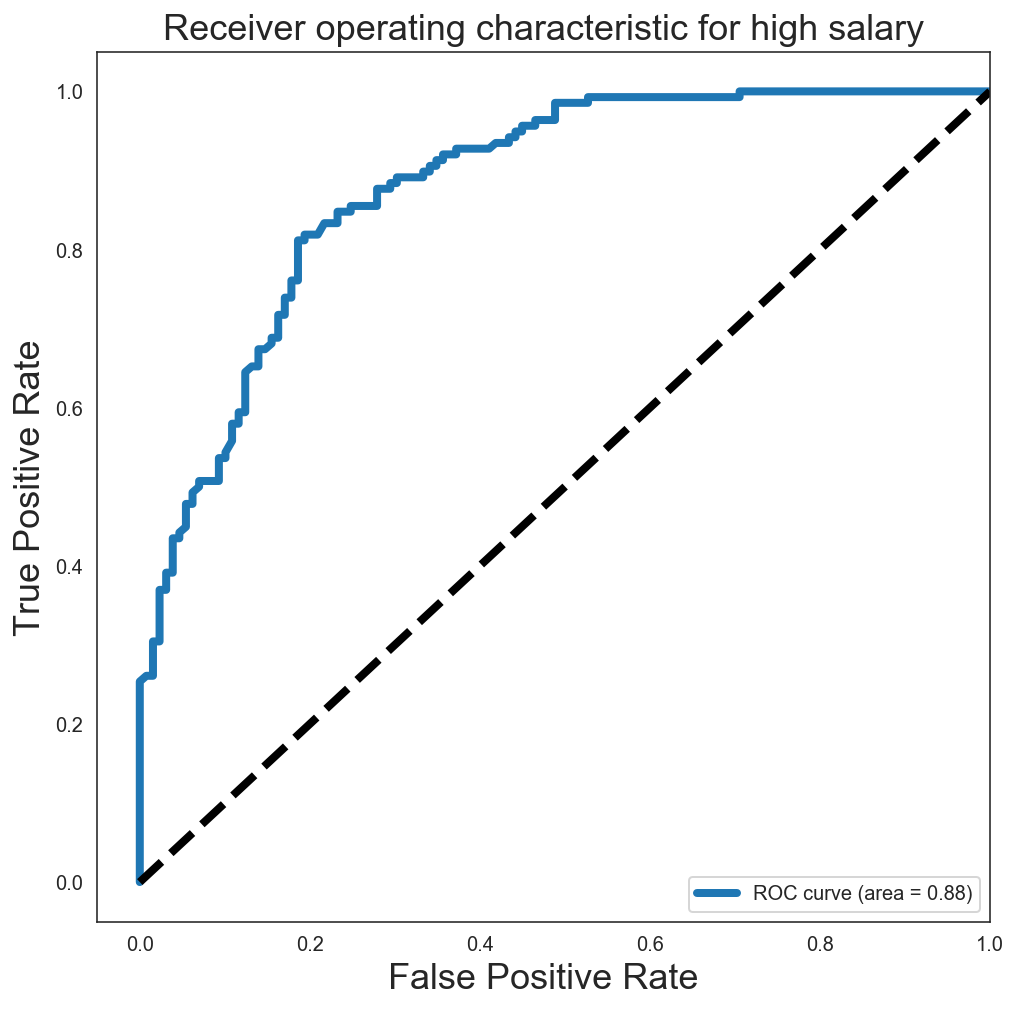

In [89]:
# Plotting ROC curve for high salary (Class 1)
fpr, tpr, thresholds = roc_curve(y_test, y_pp['class_1_pp'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for high salary', fontsize=18)
plt.legend(loc="lower right")
plt.show()

#### Bonus: 
- Adjust either model such that salary predictions are erring on the side of being conservative
- Explain the change and what are the tradeoffs
    - By changing the threshold to 87% instead of 50%, we ensure that we do not wrongly predict high salaries when they are in fact low. 
    - However, in doing so, we also reduced the Precision of Class 0 (Low Salaries), such that we're only predicting high salaries correctly 21% of the time

In [90]:
y_pp['pred_class_thresh10'] = [1 if x>=0.87 else 0 for x in y_pp['class_1_pp'].values]

confusion_mat = pd.crosstab(y_test,y_pp['pred_class_thresh10'].values,
                            rownames=['Actual'],
                            colnames=['Predicted'],margins=True)
confusion_mat

Predicted,0,1,All
Actual,,,
0,129,0,129
1,111,27,138
All,240,27,267


# Factors that distinguish between Data Scientist Jobs VS other data jobs (Q2)

In [91]:
def categorise_data_jobs(row):
    if ('data' in row) & ('scientist' in row):
        return 'data scientist'
    elif ('data' in row) & ('analyst' in row):
        return 'data analyst'    
    elif ('business' in row) & ('analyst' in row):
        return 'business analyst'   
    elif ('data' in row) & ('engineer' in row):
        return 'data engineer'   
    elif ('data' in row) & ('architect' in row):
        return 'data architect'   
    else:
        return 'uncategorised'

In [92]:
# subset dataframe 
jobs['job_titles_data'] = jobs['job_title_cleaned'].apply(lambda x: categorise_data_jobs(x))

In [93]:
len(jobs[jobs['job_titles_data']!='uncategorised'])

312

In [94]:
jobs_cat = jobs.copy()
jobs_cat = jobs_cat[jobs_cat['job_titles_data']!='uncategorised']

In [95]:
jobs_cat['data_scientist'] = jobs_cat['job_titles_data'].apply(lambda x: 1 if x=='data scientist' else 0)

In [96]:
jobs_cat['data_scientist'].value_counts()/len(jobs_cat)

0    0.727564
1    0.272436
Name: data_scientist, dtype: float64

In [97]:
X = jobs_cat['summary_cleaned']
y = jobs_cat['data_scientist']

In [98]:
tfidf = TfidfVectorizer(strip_accents='ascii', 
                        stop_words='english', 
                        ngram_range=(2,2), 
                        max_df=0.9)

Xt = tfidf.fit_transform(X)
Xt = pd.DataFrame(Xt.todense(), columns=tfidf.get_feature_names())

In [99]:
Xt.shape

(312, 31585)

In [100]:
X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.2, random_state=123, stratify=y)

In [101]:
rf = RandomForestClassifier(n_estimators=200)

rf_cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')

rf.fit(X_train, y_train)
preds = rf.predict(X_test)

confusion_mat = pd.crosstab(y_test,preds,
                            rownames=['Actual'],
                            colnames=['Predicted'],margins=True)

y_pp = pd.DataFrame(rf.predict_proba(X_test), columns=['class_0_pp', 'class_1_pp'])

print('----- Scores -----')
print('CV Score (Accuracy): {:.3f} ± {:.3f}'.format(rf_cv_scores.mean(), rf_cv_scores.std()))
print('Test Score (Accuracy): ',rf.score(X_test,y_test))
print()
print('\n----- Confusion Matrix -----')
print(confusion_mat)
print('\n----- Classification Report -----')
print(classification_report(y_test, preds))

----- Scores -----
CV Score (Accuracy): 0.807 ± 0.018
Test Score (Accuracy):  0.8571428571428571


----- Confusion Matrix -----
Predicted   0   1  All
Actual                
0          44   2   46
1           7  10   17
All        51  12   63

----- Classification Report -----
              precision    recall  f1-score   support

           0       0.86      0.96      0.91        46
           1       0.83      0.59      0.69        17

   micro avg       0.86      0.86      0.86        63
   macro avg       0.85      0.77      0.80        63
weighted avg       0.85      0.86      0.85        63



In [102]:
fi = pd.DataFrame(rf.feature_importances_, index=X_train.columns)
fi.rename(columns={0:'Feature Importance'},inplace=True)
fi.sort_values(by=['Feature Importance'], ascending=False, inplace=True)
fi.head(20)

,Feature Importance
machine learn,0.010463
statistical model,0.006418
data science,0.005489
learn algorithms,0.005372
data mining,0.004868
deep learning,0.004831
phd computer,0.004753
statistical analysis,0.004110
understanding machine,0.003760
advance analytics,0.003721


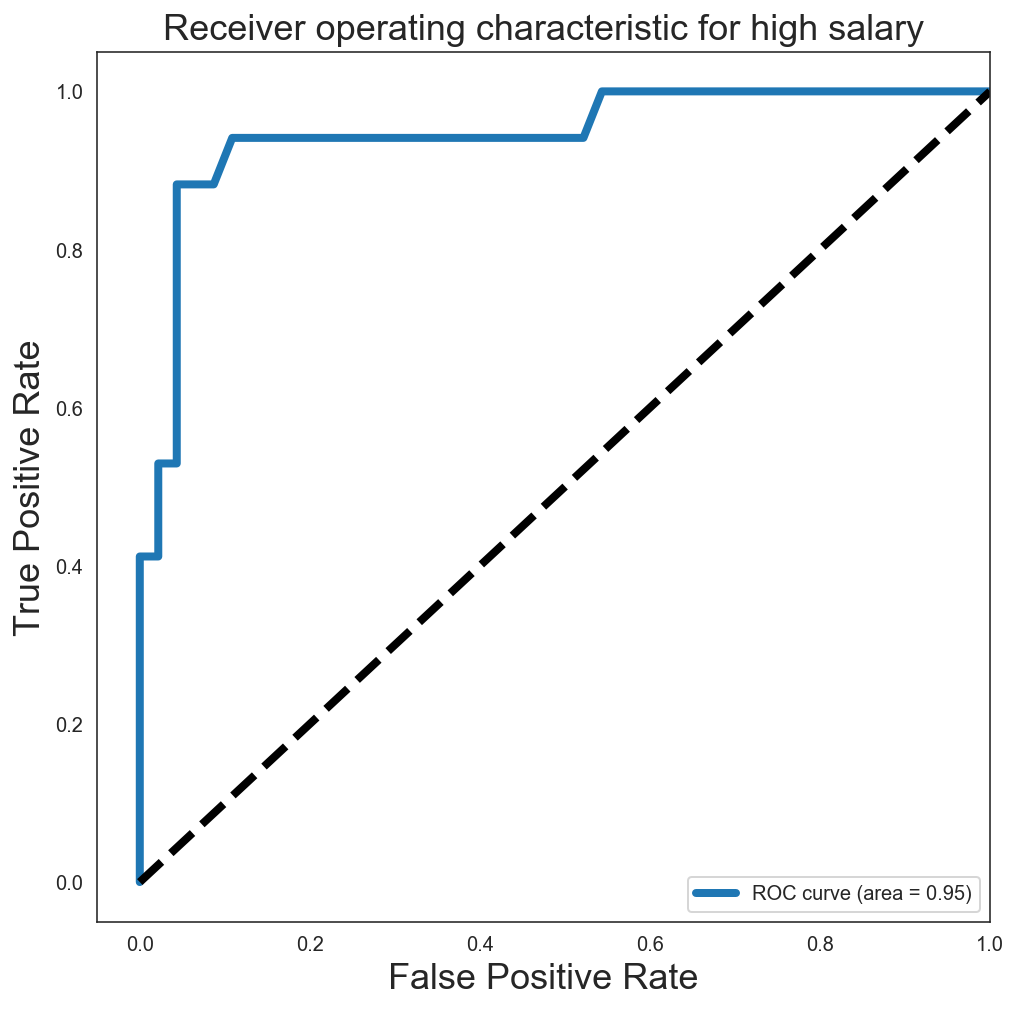

In [103]:
# Plotting ROC curve for high salary (Class 1)
fpr, tpr, thresholds = roc_curve(y_test, y_pp['class_1_pp'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for high salary', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [104]:
y_pp['pred_class_thresh20'] = [1 if x>=0.2 else 0 for x in y_pp['class_1_pp'].values]

confusion_mat = pd.crosstab(y_test,y_pp['pred_class_thresh20'].values,
                            rownames=['Actual'],
                            colnames=['Predicted'],margins=True)
confusion_mat

Predicted,0,1,All
Actual,,,
0,44,2,46
1,3,14,17
All,47,16,63


In [105]:
## try naive bayes

In [106]:
mnb = MultinomialNB()

mnb_cv_scores = cross_val_score(mnb, X_train, y_train, cv=5, scoring='accuracy')

mnb.fit(X_train, y_train)
preds = mnb.predict(X_test)

confusion_mat = pd.crosstab(y_test,preds,
                            rownames=['Actual'],
                            colnames=['Predicted'],margins=True)

y_pp = pd.DataFrame(mnb.predict_proba(X_test), columns=['class_0_pp', 'class_1_pp'])

print('----- Scores -----')
print('CV Score (Accuracy): {:.3f} ± {:.3f}'.format(mnb_cv_scores.mean(), mnb_cv_scores.std()))
print('Test Score (Accuracy): ',mnb.score(X_test,y_test))
print()
print('\n----- Confusion Matrix -----')
print(confusion_mat)
print('\n----- Classification Report -----')
print(classification_report(y_test, preds))

----- Scores -----
CV Score (Accuracy): 0.783 ± 0.020
Test Score (Accuracy):  0.8253968253968254


----- Confusion Matrix -----
Predicted   0   1  All
Actual                
0          43   3   46
1           8   9   17
All        51  12   63

----- Classification Report -----
              precision    recall  f1-score   support

           0       0.84      0.93      0.89        46
           1       0.75      0.53      0.62        17

   micro avg       0.83      0.83      0.83        63
   macro avg       0.80      0.73      0.75        63
weighted avg       0.82      0.83      0.81        63



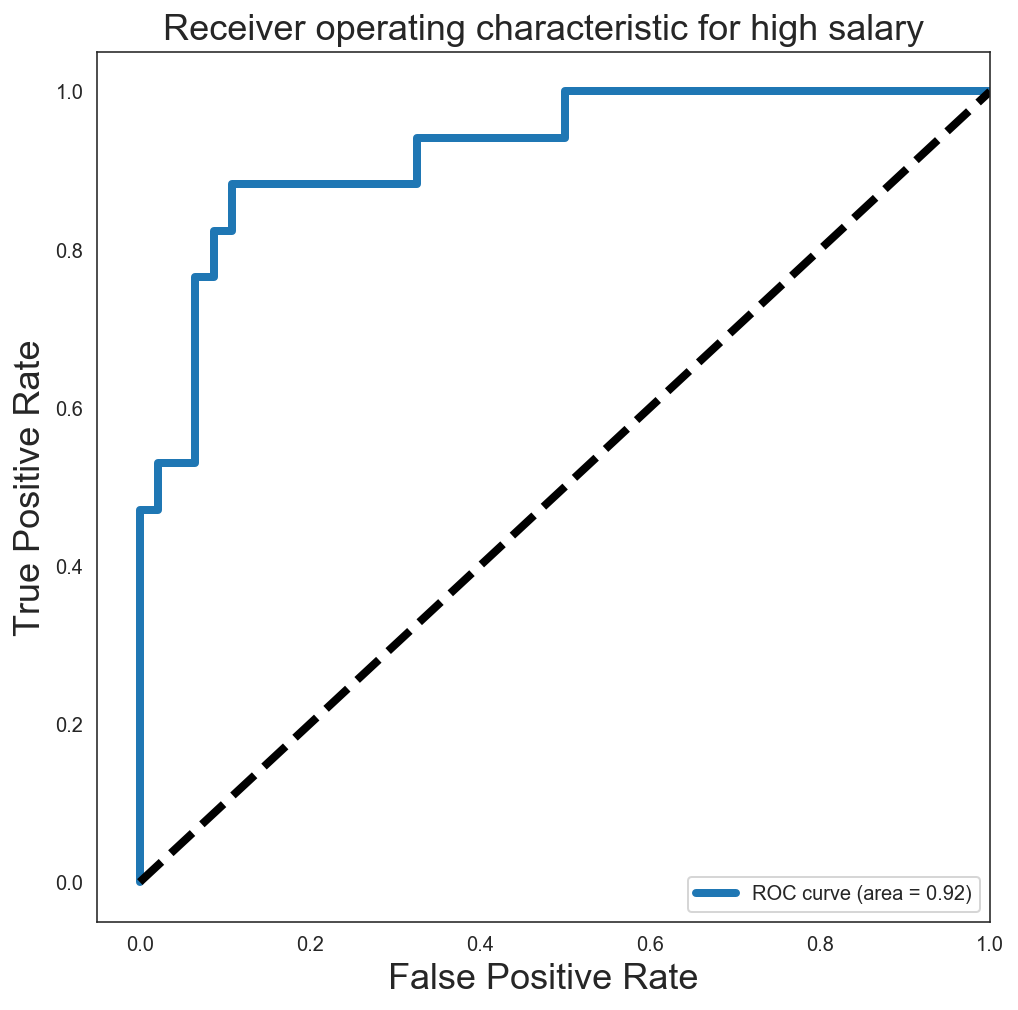

In [107]:
# Plotting ROC curve for high salary (Class 1)
fpr, tpr, thresholds = roc_curve(y_test, y_pp['class_1_pp'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for high salary', fontsize=18)
plt.legend(loc="lower right")
plt.show()

# Appendix: Web Scraping

In [270]:
import numpy as np
import pandas as pd
import re, string
from time import sleep

from bs4 import BeautifulSoup
import urllib

import os
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

In [265]:
def get_job_info(html):
    """
    Returns a dictionary of job information given a html page on a single job posting
    """

    html = BeautifulSoup(html, 'lxml')
    
    company_address = html.find_all('a', {'class': 'link dark-pink underline-hover'})
    if company_address == []:
        company_address = 'Unknown'
    else:
        company_address = company_address[0].text
    
    employment_type = html.find_all('p', {'id': 'employment_type'})
    if employment_type == []:
        employment_type = 'Unknown'
    else:
        employment_type = employment_type[0].text
        
    seniority = html.find_all('p', {'id': 'seniority'})
    if seniority == []:
        seniority = 'Unknown'
    else:
        seniority = seniority[0].text
        
    job_category = html.find_all('p', {'id': 'job-categories'})
    if job_category == []:
        job_category = 'Unknown'
    else:
        job_category = job_category[0].text    
    
    salary_type = html.find_all(
        'span', {'class': 'salary_type dib f5 fw4 black-60 pr1 i pb'})[0].text
    if salary_type == '':
        salary_type = 'Unknown'
    else:
        salary_type = salary_type
        
    job_description = html.find_all('div', {'id': 'job_description'})
    if job_description == []: 
        job_description = 'Unknown'
    else:
        job_description = job_description[0].text
    
    job_requirements = html.find_all('div', {'id': 'requirements'})
    if job_requirements == []:
        job_requirements = 'Unknown'
    else:
        job_requirements = job_requirements[0].text

    job_info = {
        'company': html.find_all('p',{'name':'company'})[0].text,
        'job_title': html.find('h1', {'id':'job_title'}).text,
        'company_address': company_address,
        'employment_type': employment_type,
        'seniority': seniority,
        'job_category': job_category,
        'salary_range': html.find_all('span', {'class': 'salary_range dib f2-5 fw6 black-80'})[0].text,
        'salary_type': salary_type,
        'job_description': job_description,
        'job_requirements': job_requirements
    }
    
    return job_info

In [264]:
def get_page_listings(job_listing_soup):
    """
    Scrapes all job information from a page listing, given the page's html
    """
    
    # get the ids for all job cards on a page listing
    job_cards = []
    for tag in (job_listing_soup.find_all('div',id=lambda x: x and 'job-card-' in x)):
        job_cards.append(tag.attrs['id'])
    
    for job_card in job_cards:
        # clicks only when the job card element is clickable
        job_card_element = WebDriverWait(driver, 15).until(
            EC.element_to_be_clickable((By.ID, job_card)))
        job_card_element.click()
        
        # retrieve html from page only after salary information is loaded
        # based on past experience, salary information tends to load the slowest
        salary_information = WebDriverWait(driver, 15).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, '.salary_type.dib.f5.fw4.black-60.pr1.i.pb')))

        job_page = driver.page_source
        html = BeautifulSoup(job_page, 'lxml')
        
        # scrape job information
        try:
            job_info = get_job_info(job_page)
            # adding the posting's url into our dictionary of job information
            job_info['url'] = driver.current_url
            query_job_list.append(job_info)
        
        # catch jobs that failed to scrape, and print URL
        except:
            print('Failed to scrape job. URL: {}'.format(driver.current_url))
        
        driver.back()

In [262]:
def retrieve_jobs_by_category():
    """
    Scrapes all job information for a given query term
    """
    
    # get html from job listings page - this will contain a pop up 
    job_listing_html = driver.page_source
    job_listing_soup = BeautifulSoup(job_listing_html, 'lxml')

    # find and close the pop up, if it pop ups
    popup = job_listing_soup.find('div', {'id': 'snackbar'})

    if popup != None:
        button = driver.find_element_by_class_name('OverlayNavigation__icon-cross___1wfSE')
        button.click()
    
    # get html from job listings page, which contains links to all the individual job postings
    job_listing_html = driver.page_source
    job_listing_soup = BeautifulSoup(job_listing_html, 'lxml')

    # scrapes job information for all the jobs on a particular page
    get_page_listings(job_listing_soup)

    # indicates if the page has a 'next' arrow or not
    next_arrows = job_listing_soup.find_all(
        'span', {'class': 'f5-5 pv2 ph3 mh1 pointer dib black-70 hover-bg-white'})
    
    # if the query only returns 1 page of listing, terminate the function here
    if len(next_arrows) == 0:
        return
    
    # otherwise, check if there is a next arrow
    next_arrow = next_arrows[-1].text == '❯'    

    while next_arrow:
        sleep(np.random.uniform(3.938, 5.398))
        
        # click on the next arrow
        button = driver.find_elements_by_class_name('hover-bg-white')[-1]
        button.click()

        sleep(np.random.uniform(5.338, 5.998))
        
        # find and close pop up, if it pops up
        job_listing_html = driver.page_source
        job_listing_soup = BeautifulSoup(job_listing_html, 'lxml')

        popup_add_skills = job_listing_soup.find('div', {'class': 'joyride'})

        if popup_add_skills != None:
            button = driver.find_element_by_class_name('joyride-tooltip__close')
            button.click()
        
        # get page listings for new page
        job_listing_html = driver.page_source
        job_listing_soup = BeautifulSoup(job_listing_html, 'lxml')
        
        # scrapes job information for current page
        get_page_listings(job_listing_soup)

        # check if there's a next error at the end of this page
        next_arrow = job_listing_soup.find_all(
            'span', {'class': 'f5-5 pv2 ph3 mh1 pointer dib black-70 hover-bg-white'}
            )[-1].text == '❯'

In [263]:
def retrieve_jobs_all(queries):
    """
    Given a list of job search query terms, saves all the jobs from each query into csv files
    """
    
    for query in queries:
        
        # open job portal website
        driver.get('https://www.mycareersfuture.sg')
        
        # wait for jobs to load
        sleep(np.random.uniform(5.338, 7.998))
        
        # search for job with query
        search_field = driver.find_element_by_id('search-text')
        search_field.send_keys(query)
        driver.find_element_by_id('search-button').click()
        sleep(np.random.uniform(7.338, 10.998))
        
        # retrieve job information for all results of the query
        # try/except allows us to scrape other queries first in the event any query fails
        global query_job_list
        try:
            retrieve_jobs_by_category()
        except:
            print('{} failed to process completely. Skipping to next query...'.format(query))
            query_job_list = []
            continue
        
        # save to csv for each query
        df = pd.DataFrame(query_job_list)
        csv_name = '_'.join(query.split(' '))
        df.to_csv('{}_jobs.csv'.format(csv_name))
        
        print('{} {} jobs scraped'.format(len(query_job_list), query))
        
        # reset list for the next query
        query_job_list = []

In [221]:
# create webdriver
chromedriver = "./chromedriver"
os.environ["webdriver.chrome.driver"] = chromedriver

In [ ]:
# start the driver and open a chrome window
driver = webdriver.Chrome(executable_path="./chromedriver")

# list of search queries
queries = ['ai specialist', 'data analyst', 'data analysis', 'data scientist', 'data science', 
           'machine learning', 'machine learning engineer', 'data engineer', 'big data',
           'ai', 'artificial intelligence', 'python', 'sql', 'data architect',
           'business intelligence']

# list of jobs per category to save individual job information dictionaries into
query_job_list = []

In [267]:
# run this cell to start scraping
retrieve_jobs_all(queries)
driver.close()

2 ai specialist jobs scraped
117 data analyst jobs scraped
297 data analysis jobs scraped
123 data scientist jobs scraped
112 data science jobs scraped
281 machine learning jobs scraped
14 machine learning engineer jobs scraped
113 data engineer jobs scraped
281 big data jobs scraped
145 ai jobs scraped
99 artificial intelligence jobs scraped
193 python jobs scraped
329 sql jobs scraped
32 data architect jobs scraped
126 business intelligence jobs scraped
